# Machine Learning Project
## Mbusu-Team

### **House Prices Dataset**

### **Data Understanding**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sb
import re
from scipy.stats import entropy
import math
import sys
plt.style.use('ggplot')


hue_order = ["HIGH","MEDIUM","LOW"]
color = ["#BF4E30","#2E86AB","#E7A012"]
palette = {
    'LOW': color[0],
    'MEDIUM': color[1],
    'HIGH': color[2],
}
TARGET_FEATURE = 'SalePrice'
TARGET_FEATURE_CONTI = 'salePriceNum'
TARGET_FEATURE_VALUES = ['LOW', 'MEDIUM', 'HIGH']

#### INFORMATION GAIN FUNTION 

In [2]:
def IG(df, target, attribute):

    df_sub = []

    for value in df[attribute].unique():
        df_sub.append( df[df[attribute] == value] )
        
    counts = df[target].value_counts()
    probs = counts / len(df)
    e = -np.sum(probs * np.log2(probs))

    information_gain = e 
    for df_s in df_sub:
        counts = df_s[target].value_counts()
        probs = counts / len(df_s)
        e_s = -np.sum(probs * np.log2(probs))
        information_gain -= len(df_s) / len(df) * e_s

    return information_gain


In [3]:
def aggregate(df, new_name, threshold, attribute):
    values_count= df[attribute].value_counts()
    for i in values_count.keys():
        if values_count[i] <= threshold:
            df[attribute] = df[attribute].replace([i], new_name)
    return df

###### indepence_test_categoric

In [4]:

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    
def label_group_bar_table(ax, df):
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            if pos % 3 == 0: add_line(ax, pos*scale, ypos - .052)
            pos += rpos
        add_line(ax, pos*scale , ypos - .052)
        ypos -= .05

def barplot_diffvalues(dataset, feature_name):
    df = dataset.reset_index().groupby([feature_name, TARGET_FEATURE]).sum()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    #print(dataset)
    dataset.pivot_table(index = [feature_name, TARGET_FEATURE], columns=['__Type']).plot(kind='bar', ax=ax, width=.7)
    
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_title('Expected/Observed Frequencies')
    ax.set_xlabel(f'{feature_name}/{TARGET_FEATURE}', labelpad=40)
    ax.set_ylabel(f'{TARGET_FEATURE}')
    plt.legend(['Expected', 'Observed'])
    label_group_bar_table(ax, df)

    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    plt.show()

def stattest_quali(df, feature_name: str, fig_width=15, fig_height=3, typeplot = 'heatmap' ):

    #
    # chi-square test and expected frequencies matrix
    #
    crosstab = pd.crosstab(df[feature_name], df[TARGET_FEATURE])
    chi_square_args = crosstab.values
    _, p_value, _, _ = stats.chi2_contingency(chi_square_args)

    expf_crosstab = pd.DataFrame(crosstab)
    for idx in expf_crosstab.index:
        for col in expf_crosstab.columns:
            expf_crosstab.at[idx, col] = crosstab.loc[idx].values.sum() * crosstab[col].values.sum() / crosstab.values.sum()


    #
    # observed/expected frequencies heatmaps
    #
    fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_height * 2))
    sb.heatmap(crosstab.T, ax=ax[0], annot=True, cmap='coolwarm', fmt='.2f')
    sb.heatmap(expf_crosstab.T, ax=ax[1], annot=True, cmap='coolwarm', fmt='.2f')
    ax[0].set_title('Observed Frequencies')    
    ax[1].set_title('Expected Frequencies')
    fig.tight_layout()
    plt.show()

    if(typeplot == 'heatmap'):
        
        #
        # frequencies difference heatmap
        #
        obsexp_diff_df = crosstab - expf_crosstab
        fig = plt.figure(figsize=(fig_width, fig_height))
        plt.title("Frequency Differences (Observed - Expected)")
        sb.heatmap(obsexp_diff_df.T, annot=True, cmap='vlag', fmt='.2f')
    
    elif typeplot == 'barplot':
        #
        # observed/expected frequencies barplot
        #
        value_vars_x = [val + '_x' for val in TARGET_FEATURE_VALUES]
        value_vars_y = [val + '_y' for val in TARGET_FEATURE_VALUES]
        value_vars_xy = value_vars_x + value_vars_y
        obs_exp_df = pd.merge(crosstab, expf_crosstab, on=[feature_name]).reset_index()
        obs_exp_df = pd.melt(obs_exp_df, id_vars=[feature_name], value_vars=value_vars_xy)
        obs_exp_df['__Type'] = obs_exp_df[TARGET_FEATURE]

        for val in value_vars_x: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__OBS'
        for val in value_vars_y: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__EXP'

        for price in TARGET_FEATURE_VALUES:
            for obs_exp in ['x', 'y']:
                obs_exp_df.loc[obs_exp_df[TARGET_FEATURE] == price + '_' + obs_exp, TARGET_FEATURE] = price[0]

        barplot_diffvalues(obs_exp_df, feature_name)

    #
    # chi-square test outcome
    #
    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    print("Chi-square Test - Outcome")
    print("P-Value:", p_value, p_value_info)

###### indepence_test_numeric

In [5]:
def stattest_quanti(df, feature_name: str, target = TARGET_FEATURE ,low_limit=0, upper_limit=100):

    #
    # plot means w.r.t. target categories
    #
    df_conti_origin = df[[feature_name, target, TARGET_FEATURE_CONTI]] if ( target == TARGET_FEATURE) else None
    df_categ_origin = df[[feature_name, target]]
    df = df_categ_origin.groupby(target)
    mean_df = df.mean().reset_index().rename(columns={feature_name: feature_name + ' (AVG)'})

    num = 3
    if df_conti_origin is None:
        num = 2
    _, ax = plt.subplots(1, num, figsize=(20, 5))

    mean_df.plot(kind='bar', x=target, ax=ax[0])
    for container in ax[0].containers:
        ax[0].bar_label(container, fmt='%.1f')
    ax[0].set_ylim(low_limit, upper_limit)
    ax[0].tick_params(labelrotation=0)

    sb.histplot(x=feature_name, hue=target, data=df_categ_origin, kde=True, ax=ax[1])
    for tval in TARGET_FEATURE_VALUES:
        ax[1].axvline(x=df_categ_origin[df_categ_origin[target] == tval][feature_name].mean(), color='gray', ls='--', lw=1.5)
    
    if df_conti_origin is not None : sb.regplot(x=feature_name, y=TARGET_FEATURE_CONTI, data=df_conti_origin, line_kws={"color": "darkred"}, ax=ax[2])
    
    #
    # perform ANOVA test
    #
    anova_args = tuple(df[feature_name].apply(list).reset_index()[feature_name])
    f_statistic, p_value = stats.f_oneway(*anova_args)

    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    print("ANOVA Test - Outcome")
    print("P-Value:", p_value, p_value_info)

###### Numeric Numeric Correlation

In [6]:
def correlation(df, n1, n2):

    sb.regplot(x=n1, y=n2, data=df, line_kws={"color": "darkred"})
    
    corr, p_values = stats.pearsonr(df[n1], df[n2])
    
    print(corr, p_values)

#### Mean

In [7]:
def mean_attribute(df, attribute):
    mean_low = df[ ( df["SalePrice"] == 'LOW' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_medium = df[ ( df["SalePrice"] == 'MEDIUM' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_high = df[ ( df["SalePrice"] == 'HIGH' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    return (mean_low, mean_medium, mean_high)



#### PLOTS

##### Plot frequencies and percentages

In [8]:
def frequencies_and_percentages(df, target, attribute, figsize=(15,5), rotation=0, display=False):
    fig, ax = plt.subplots(1,2, figsize=figsize)

    dfp = df[[attribute,target]].pivot_table(index = attribute, columns=[target],  aggfunc=len)
    dfp = dfp.fillna(0)
    dfpp = dfp.pipe(lambda d : 100*d.div(sum(d[v] for v in df[target].unique()), axis='index'))
    if display:
        display(dfpp)
    dfp.plot(kind='bar', ax=ax[0]  , title = f"Count by {attribute}" ,  color = color)
    dfpp.plot(kind='bar',ax=ax[1] , stacked=True , title  = f"Percentage by {attribute}", legend = False , color = color )
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=rotation, horizontalalignment='right')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=rotation, horizontalalignment='right')

##### Plot frequencies and percentages for numerical attributes

In [9]:
def frequencies_and_percentages_numeric(df, target, attribute, bin, rotation=0, figsize=(15,5),display=False):
    fig, ax = plt.subplots(1,2, figsize=figsize)
    df1 = df.copy()
    df1[attribute] = pd.qcut(df1[attribute], q=bin)
    regexp_1 = re.compile(r".(\-?\d+)\.?\d*, ?(\-?\d+)\.?\d*.")
    for i in df1[attribute].unique():
        re_match = regexp_1.match(str(i))
        if re_match is not None:
            val = [re_match[1], re_match[2]]
            for j in range(0, len(val)):
                    if val[j] == "-0":
                         val[j] = "0"
            df1[attribute] = df1[attribute].replace(i, str(val[0])+" - "+str(val[1]))
    dfp = df1[[attribute,target]].pivot_table(index = attribute, columns=[target],  aggfunc=len)
    dfp = dfp.fillna(0)
    dfpp = dfp.pipe(lambda d : 100*d.div(sum(d[v] for v in df1[target].unique()), axis='index'))
    if display:
        display(dfpp)
    dfp.plot(kind='bar', ax=ax[0]  , title = f"Count by {attribute}" ,  color = color)
    dfpp.plot(kind='bar',ax=ax[1] , stacked=True , title  = f"Percentage by {attribute}", legend = False , color = color )
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=rotation, horizontalalignment='right')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=rotation, horizontalalignment='right')

In [10]:
def category_common_analysis(data, x, target ,palette, histplot = True, percentages=True, count = None, display=True, figsize=(15,5), rotation = 0):
    if histplot:
        plt.figure(figsize = figsize)
        sb.histplot(x = data[x], multiple='stack', hue = target,  data = data, hue_order = hue_order, palette = palette, alpha=1)
    if percentages:
        frequencies_and_percentages(data, target, x,figsize=figsize,rotation=rotation)
    if display:
        if count is None:
            print(data[x].value_counts())
        else :
            print(data[x].value_counts()[count])

##### Histplot

In [11]:

def histplot(df,target, attribute, bins = None , figsize=(15,5), multiple='stack', alpha=1 ):
    plt.figure(figsize = figsize)
    if bins is None:
        sb.histplot(x = df[attribute], hue = target, data = df, kde=True , hue_order = hue_order, palette = palette, multiple=multiple,alpha=alpha)
    else:
        sb.histplot(x = df[attribute], hue = target, data = df, kde=True , hue_order = hue_order, palette = palette, bins = bins , multiple=multiple ,common_bins= True, alpha=alpha)
    plt.show()

#### Read data

In [12]:
df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv', keep_default_na = False, low_memory= False )
df["salePriceNum"] = df.SalePrice.rename("salePriceNum")
df["SalePrice"] = pd.cut(df["salePriceNum"], bins = [0,150000,300000 - 1 ,int(sys.maxsize)], labels=["LOW","MEDIUM","HIGH"])

In [13]:
df.shape

(1460, 82)

In [14]:
df.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,salePriceNum
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### View Data

In [15]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,salePriceNum
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,2,2008,WD,Normal,MEDIUM,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,5,2007,WD,Normal,MEDIUM,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,9,2008,WD,Normal,MEDIUM,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,2,2006,WD,Abnorml,LOW,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,12,2008,WD,Normal,MEDIUM,250000


#### Info data

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   int64   
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   object  
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   in

#### Classes

In [17]:
df.SalePrice.unique()

['MEDIUM', 'LOW', 'HIGH']
Categories (3, object): ['LOW' < 'MEDIUM' < 'HIGH']

MEDIUM    726
LOW       619
HIGH      115
Name: SalePrice, dtype: int64

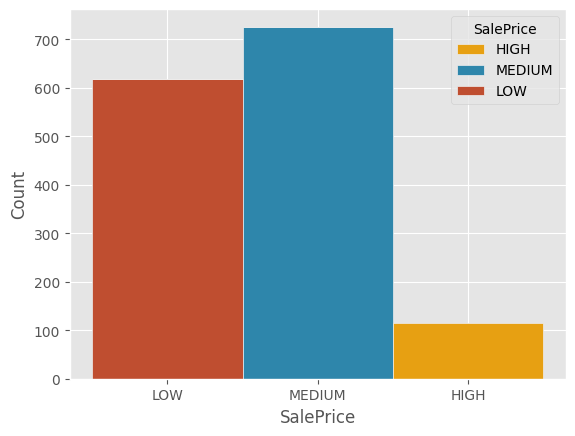

In [18]:
sb.histplot(x = 'SalePrice', multiple='stack', hue = "SalePrice",  data = df, hue_order = hue_order, palette = palette, alpha=1)
df["SalePrice"].value_counts()

#### Undestanding the effect of the attributes

##### ID

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.00000000e+00, 1.99931507e+00, 2.99863014e+00, ...,
        1.45800137e+03, 1.45900068e+03, 1.46000000e+03]),
 <BarContainer object of 1460 artists>)

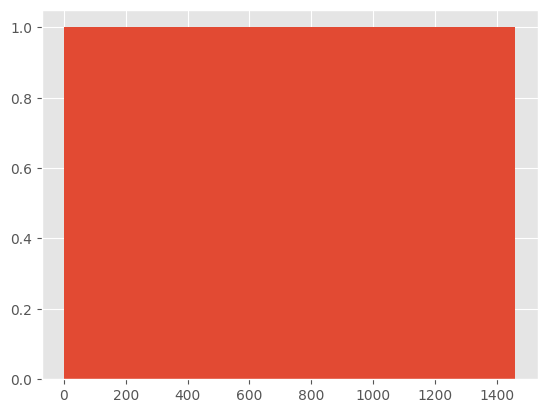

In [19]:
plt.hist(df["Id"], bins= len(df))

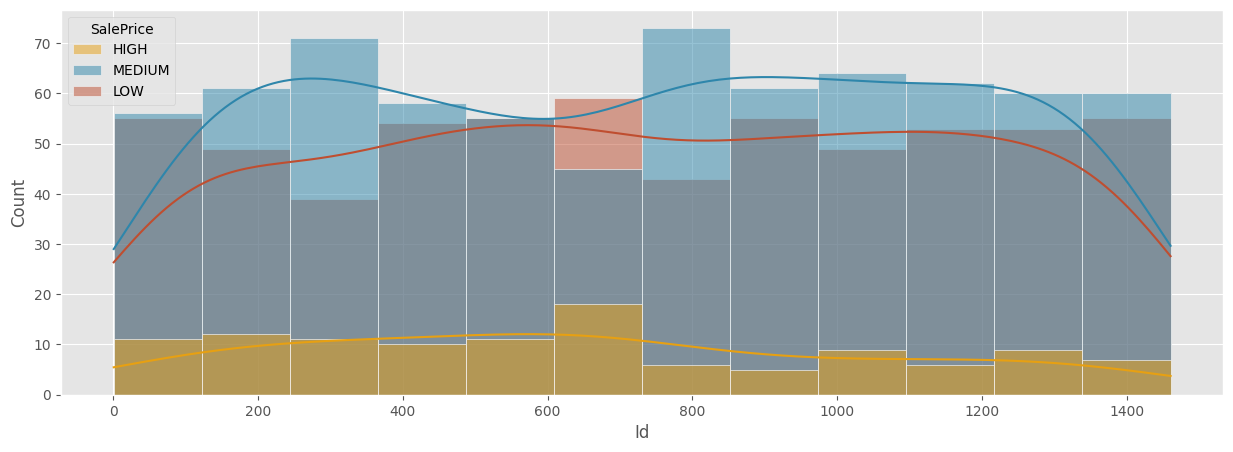

In [20]:

histplot(df,'SalePrice',"Id",multiple='layer',alpha=0.5)

In [21]:
print("Max Entropy ( Log n ) -> " + str(math.log(len(df), 2)))

counts = df['Id'].value_counts()
probs = counts / len(df)
e = -np.sum(probs * np.log2(probs))
print("Entropy -> "+ str(e))

Max Entropy ( Log n ) -> 10.51175265376738
Entropy -> 10.511752653767381


##### MSSubClass

In [22]:
df["MSSubClass"] = df["MSSubClass"].astype("category")

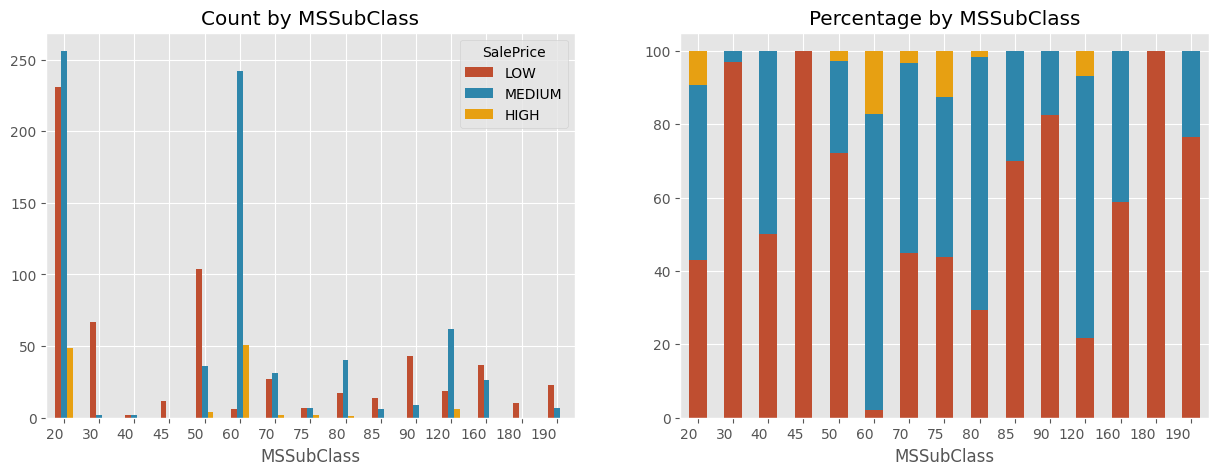

In [23]:
frequencies_and_percentages(df, 'SalePrice', 'MSSubClass')

In [24]:
IG(df,"SalePrice","MSSubClass")

/home/andrea/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.28611883641757957

##### HouseStyle

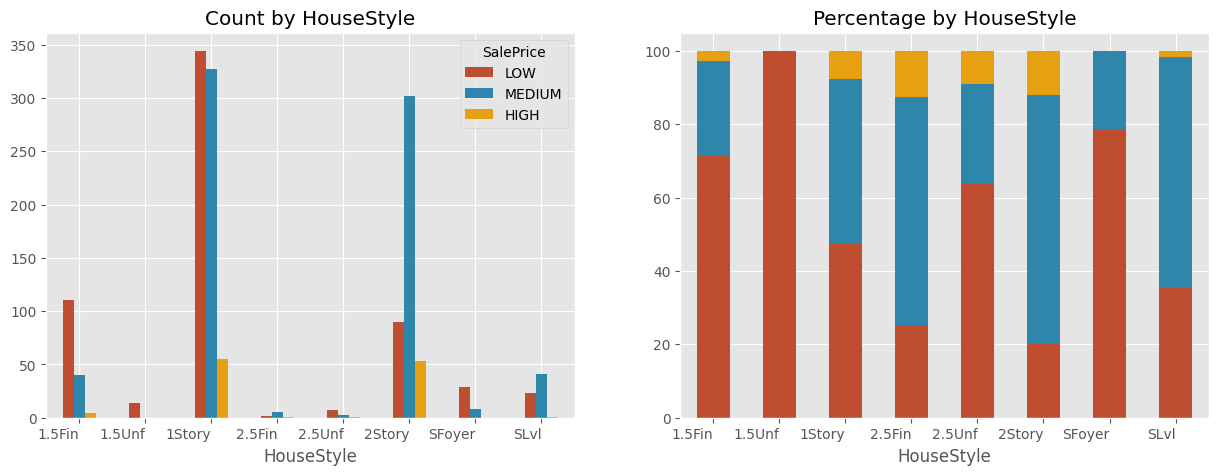

In [25]:
frequencies_and_percentages(df, 'SalePrice', 'HouseStyle')

##### MSZoning

In [26]:
df["MSZoning"] = df["MSZoning"].astype("category")

In [27]:
IG(df, "MSZoning", "SalePrice")


/home/andrea/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.12336354296168264

<AxesSubplot: >

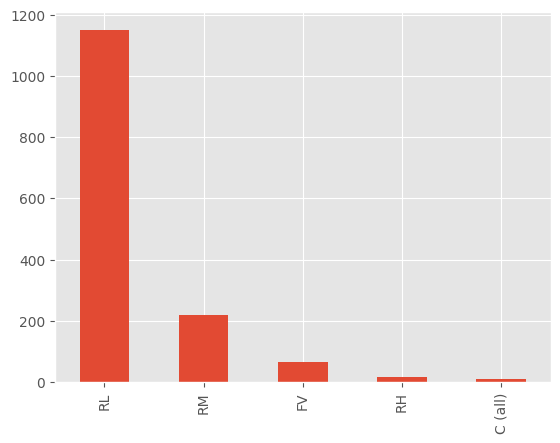

In [28]:
df["MSZoning"].value_counts().plot(kind="bar")

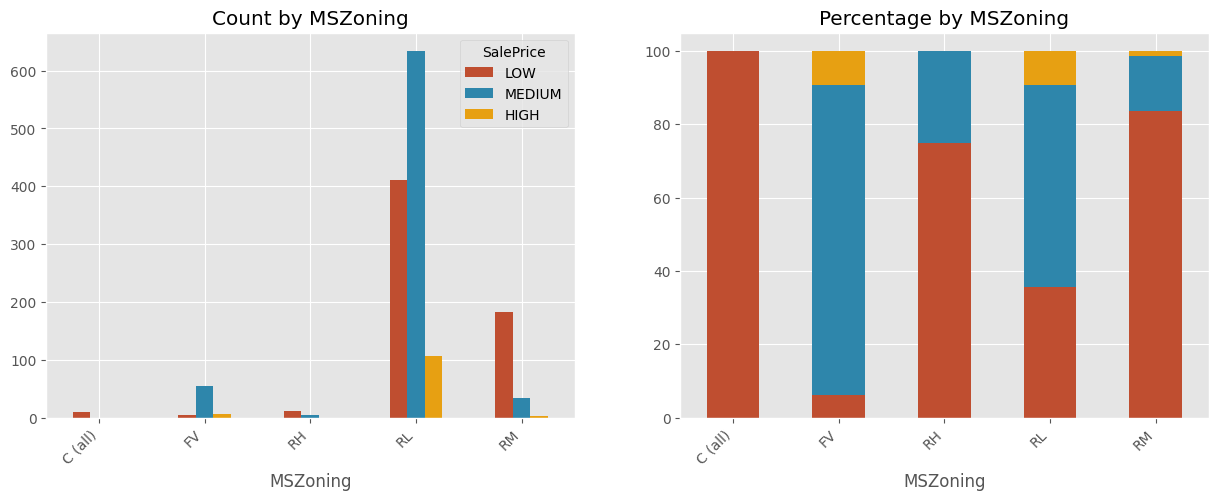

In [29]:
frequencies_and_percentages(df, 'SalePrice', 'MSZoning', rotation=45)

##### YearBuilt

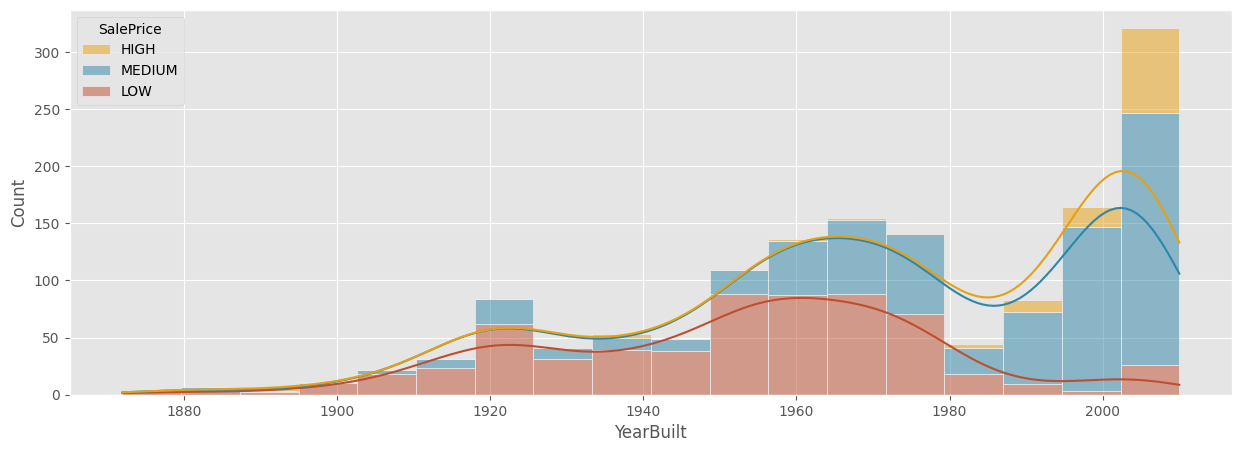

In [30]:
histplot(df,'SalePrice',"YearBuilt",alpha=0.5)
    

##### LotFrontage

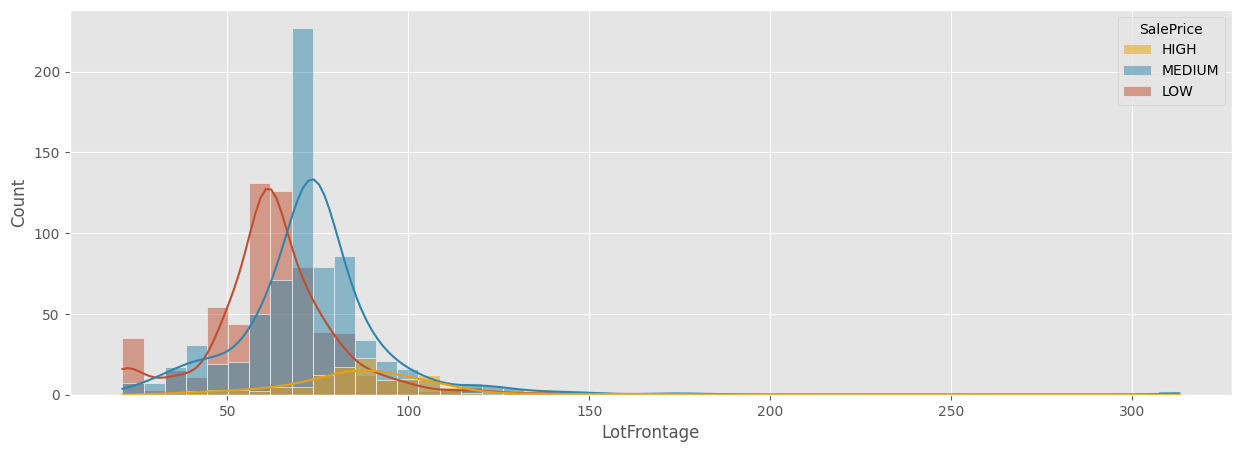

In [31]:
mean_values = mean_attribute(df, "LotFrontage")

for ind , e  in df.iterrows():
    if e["LotFrontage"] == "NA":
        if(e["SalePrice"] == "LOW"):
            df.at[ind, "LotFrontage"] = mean_values[0]
        elif e["SalePrice"] == "MEDIUM":
            df.at[ind, "LotFrontage"] = mean_values[1]
        else:
            df.at[ind, "LotFrontage"] = mean_values[2]


df["LotFrontage"] = df["LotFrontage"].astype("int")


histplot(df,'SalePrice',"LotFrontage", multiple='layer', bins=50, alpha=0.5)


##### LotArea

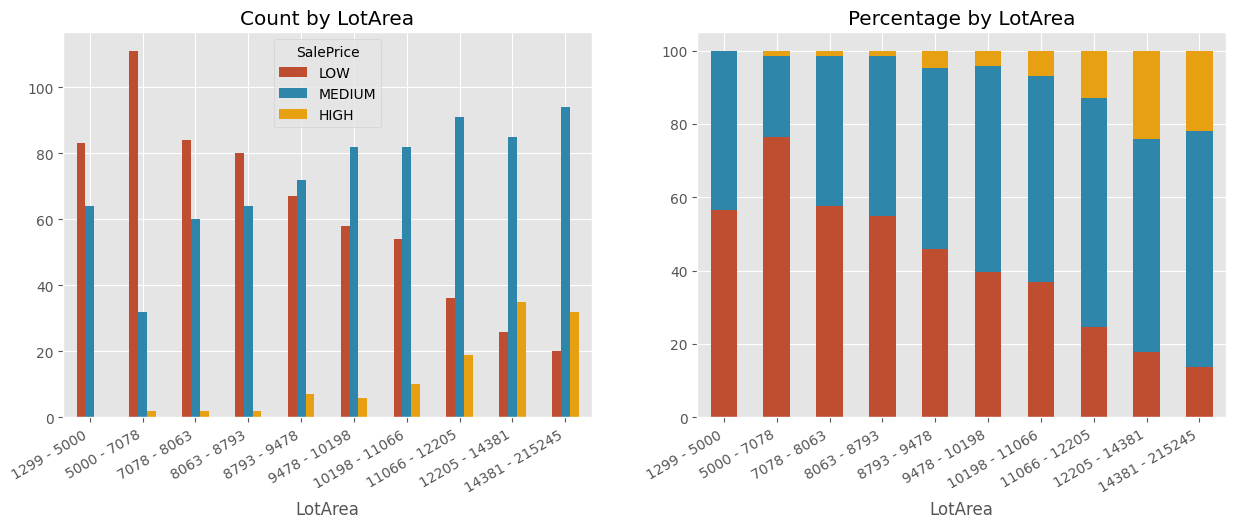

In [32]:
# As we can see from the graphs, the l the lot area the higher the price of the house.
# We think that it is useful to split the values of the attribute into bins.
frequencies_and_percentages_numeric(df, 'SalePrice', 'LotArea', rotation=30, bin = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

##### Street

Pave    1454
Grvl       6
Name: Street, dtype: int64


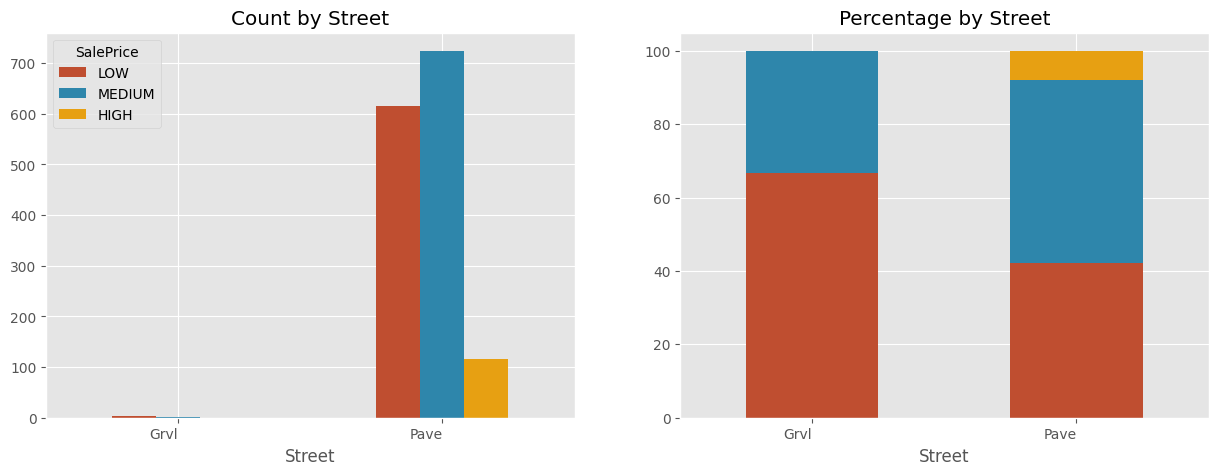

In [33]:
#Given that the training is strongly unbalanced
df['Street'] = df['Street'].astype('category')
category_common_analysis(data=df, x='Street',target='SalePrice',histplot=False, palette=palette)

##### Alley

NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64


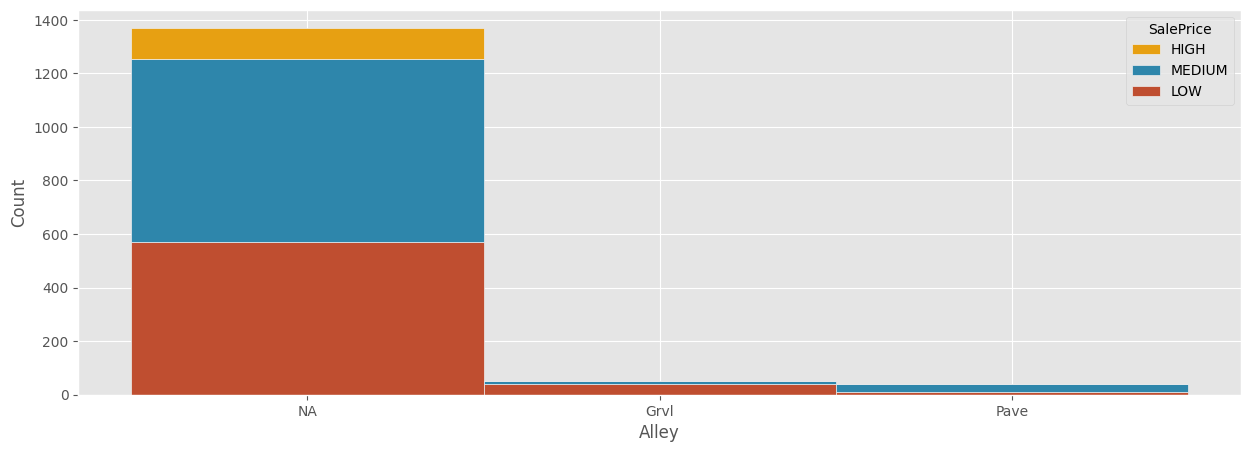

In [34]:
category_common_analysis(data=df, x='Alley',target='SalePrice',percentages=False, palette=palette)


#### LotShape

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


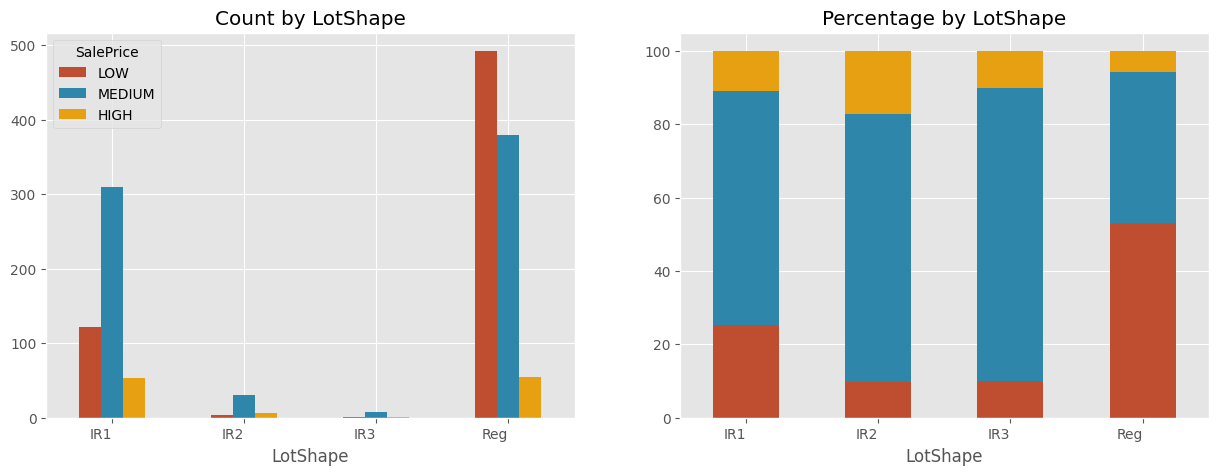

In [35]:

# to be verified with chi-squared test
# IR2 and IR3 can be aggregated in a new category
#we can see that in proportion R1 and Reg can be significantly different
category_common_analysis(data=df, x='LotShape',target='SalePrice',histplot=False, palette=palette)

#### LandContour

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


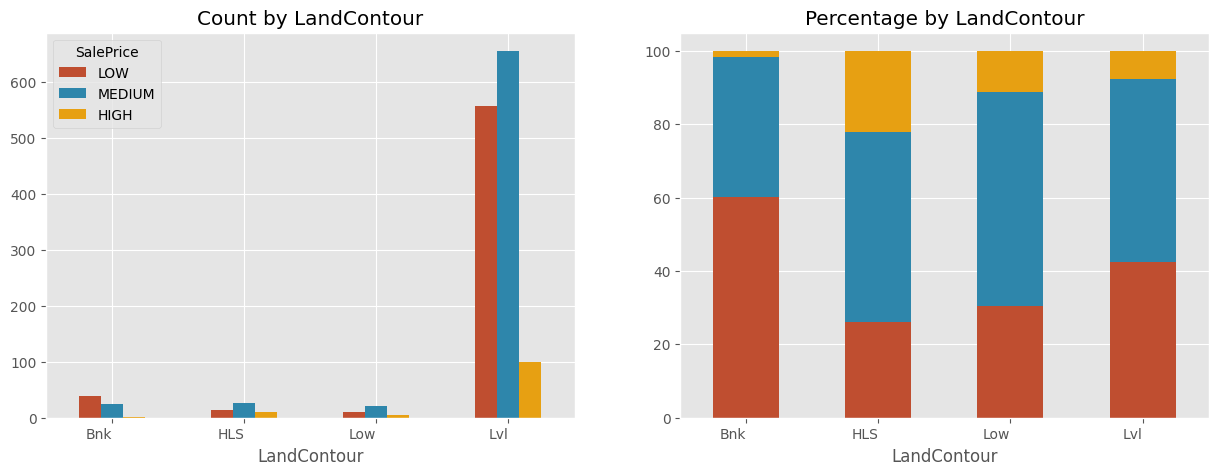

In [36]:
# maybe not enough values for a good model, we do not know if they are significant
category_common_analysis(data=df, x='LandContour',target='SalePrice', palette=palette, histplot=False)

#### Utilities

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


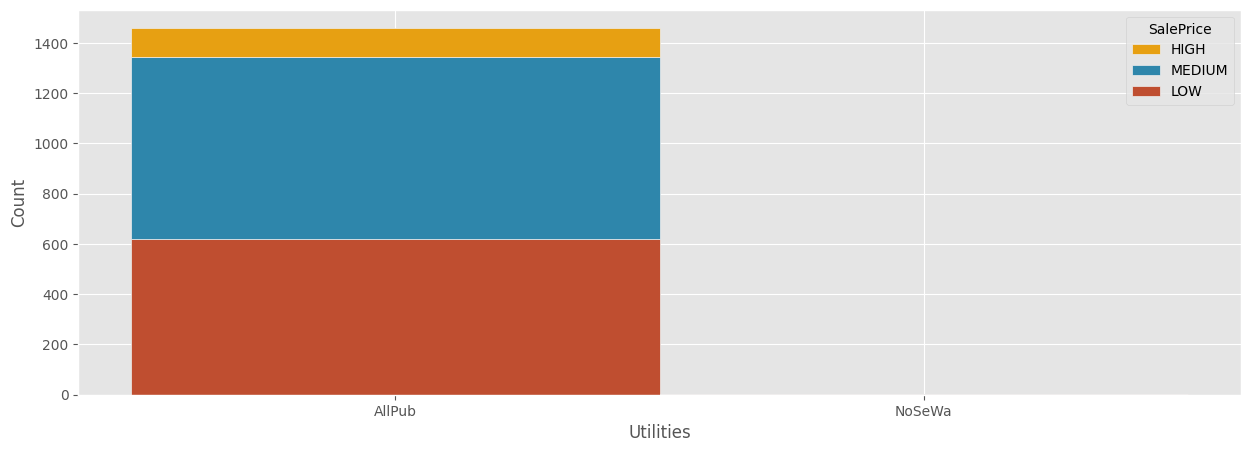

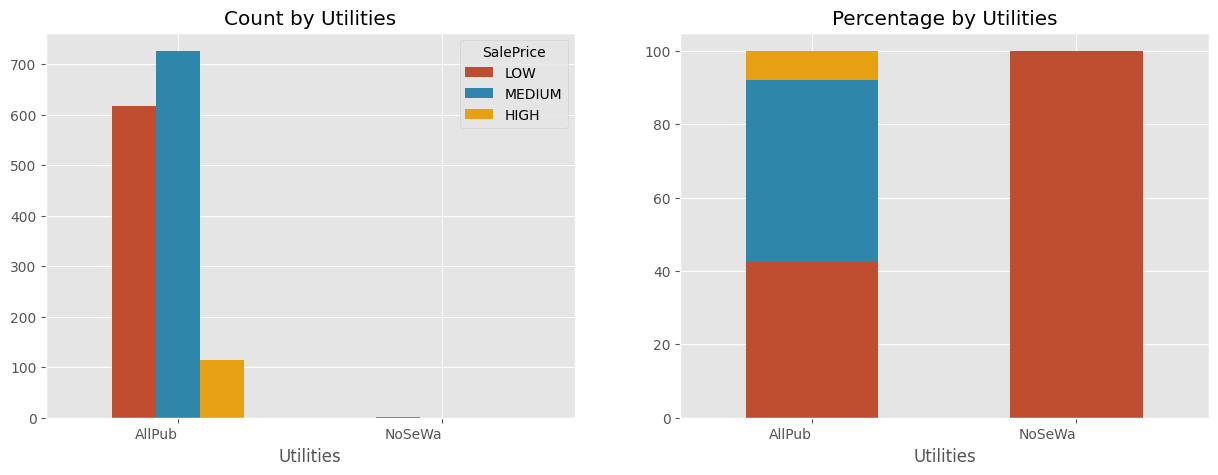

In [37]:
# All the houses (except one) have all the utilies
#Although it is considered to be a useful element, we cannot use this attribute.
category_common_analysis(data=df, x='Utilities',target='SalePrice', palette=palette)

#### LotConfig

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


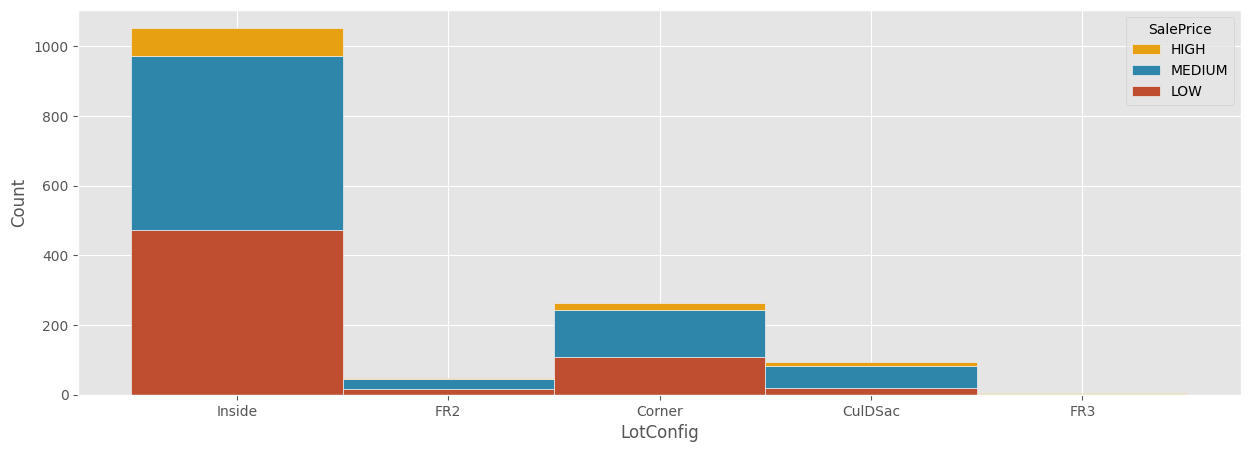

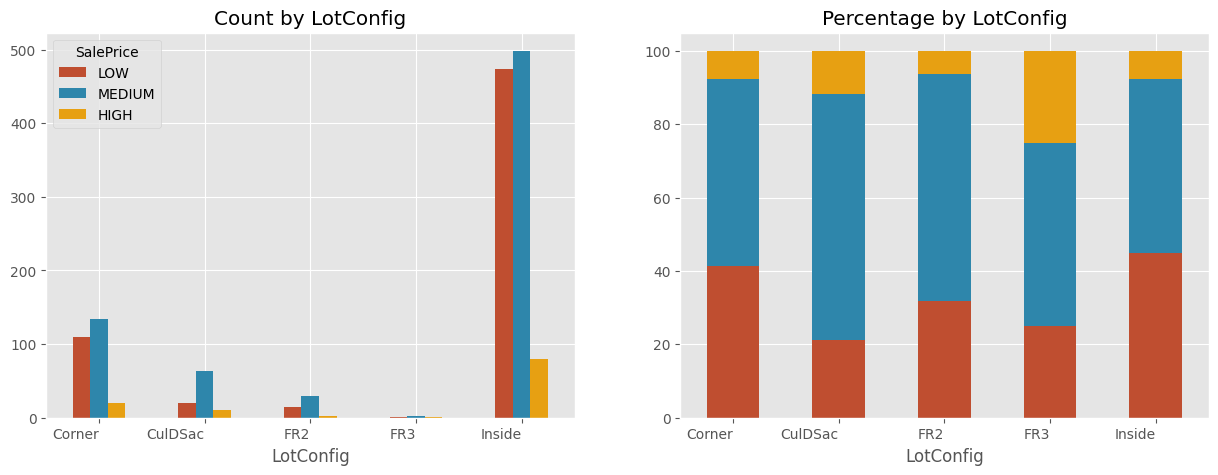

In [38]:
#it can be seen that for some values there are not enough sample, however it seems that the other attributes have a similar distribution
#The attribute can be removed since it would not be useful to the model

category_common_analysis(data=df, x='LotConfig',target='SalePrice', palette=palette)

#### LandSlope

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


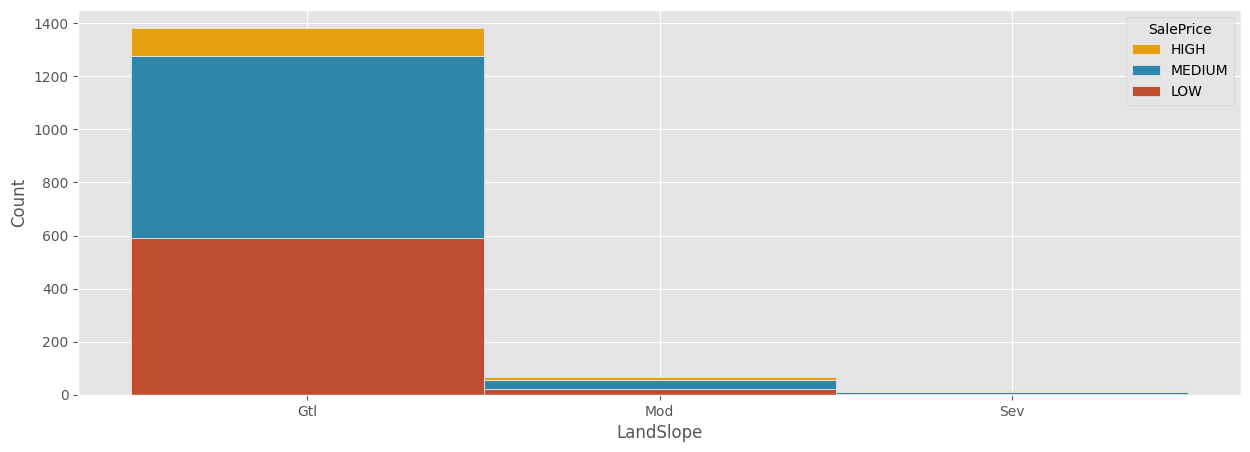

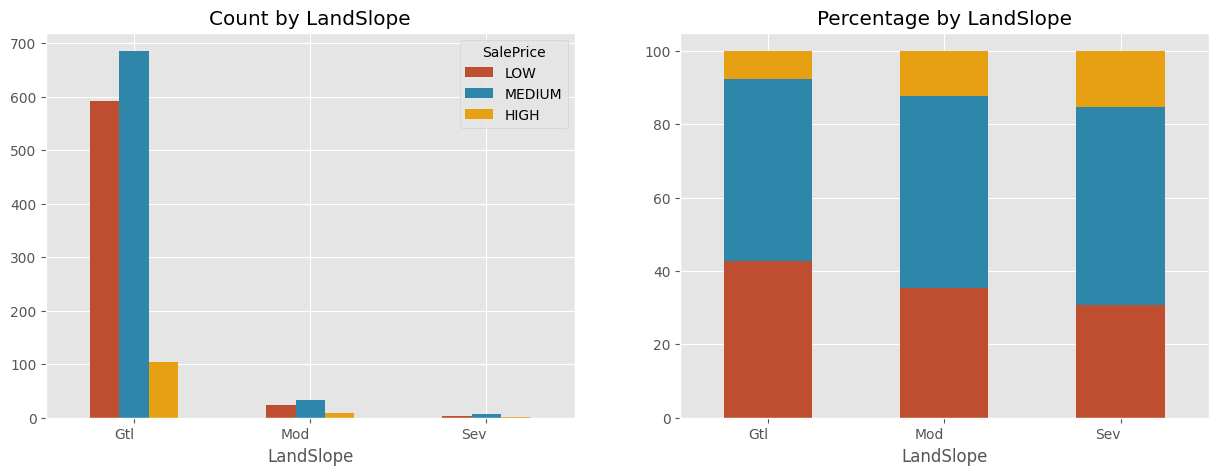

In [39]:
#la pendenza del terreno non dovrebbe influenzare il livello della proprietà
#Troppi pochi campioni
category_common_analysis(data=df, x='LandSlope',target='SalePrice', palette=palette)

#### Neighborhood

Null values: 0
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
Other       72
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Name: Neighborhood, dtype: int64


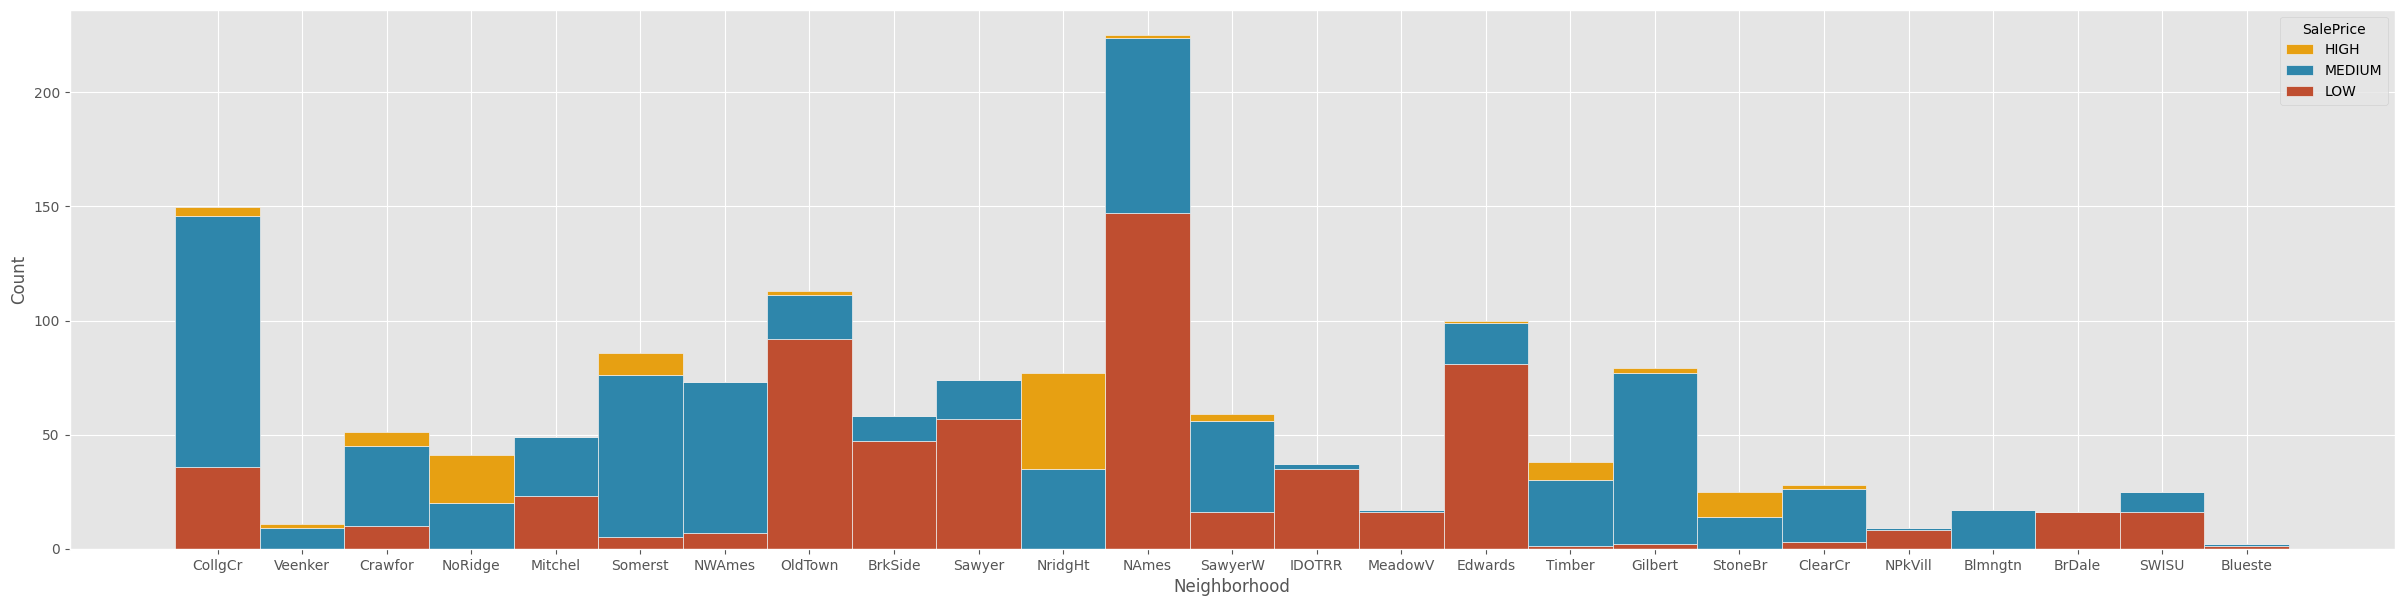

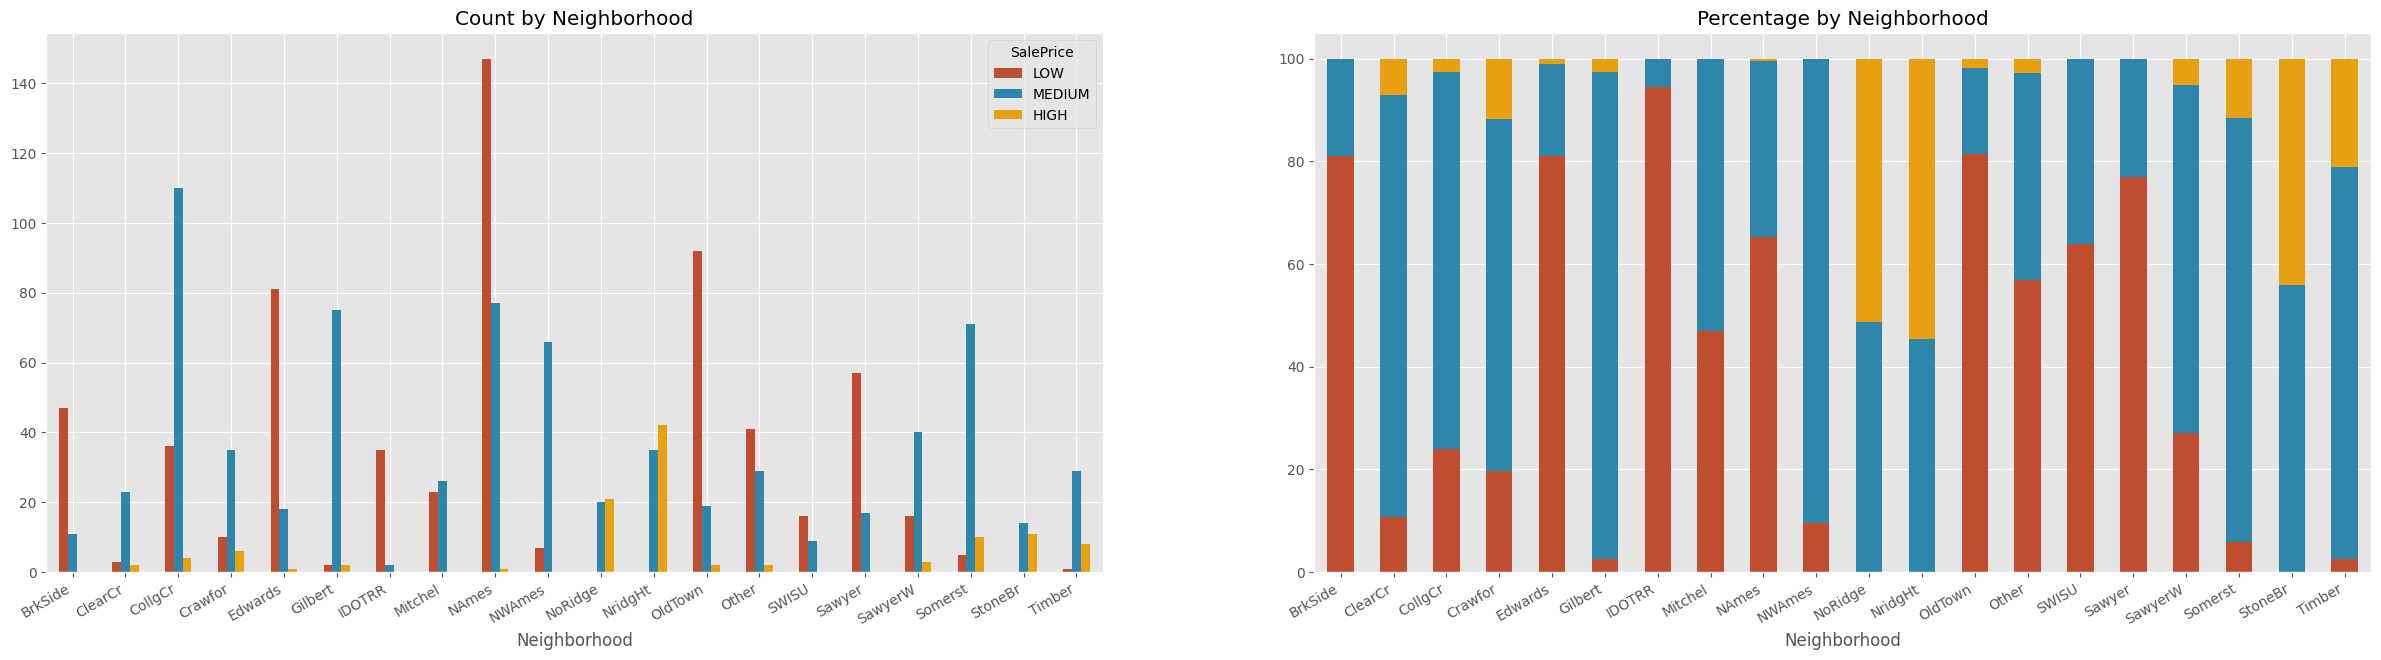

In [40]:
print(f"Null values: {df['Neighborhood'].isna().sum()}")
plt.figure(figsize = (30,7))
df1 = df.copy()

sb.histplot(x = df['Neighborhood'], multiple='stack', hue = df.SalePrice,  data = df['Neighborhood'], hue_order = hue_order, palette = palette, alpha=1)
df1 = aggregate(df = df1, attribute='Neighborhood', new_name="Other", threshold=20)
category_common_analysis(data=df1, x='Neighborhood',target='SalePrice', rotation=30, palette=palette, figsize=(30,7), histplot=False)

#### Condition1

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64


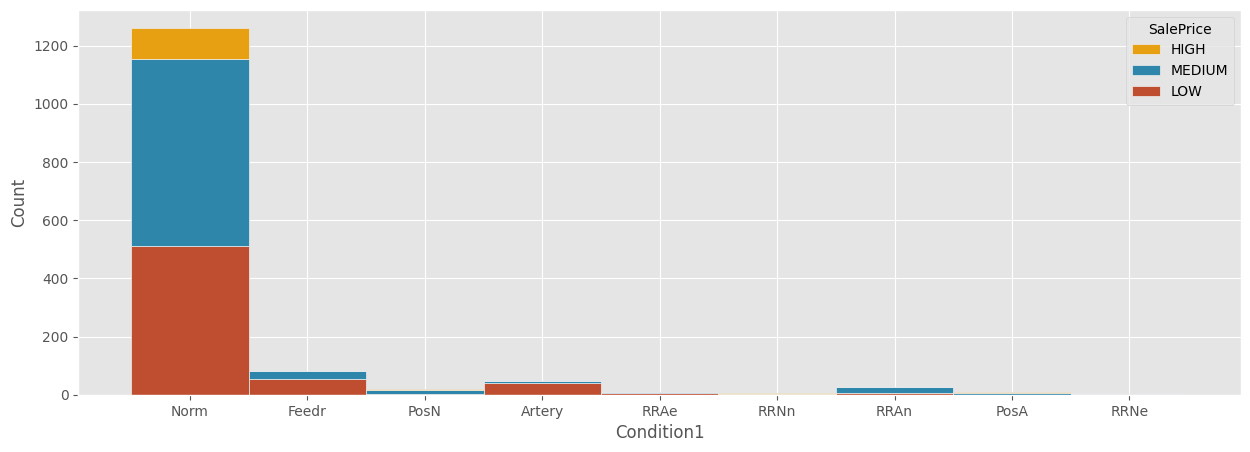

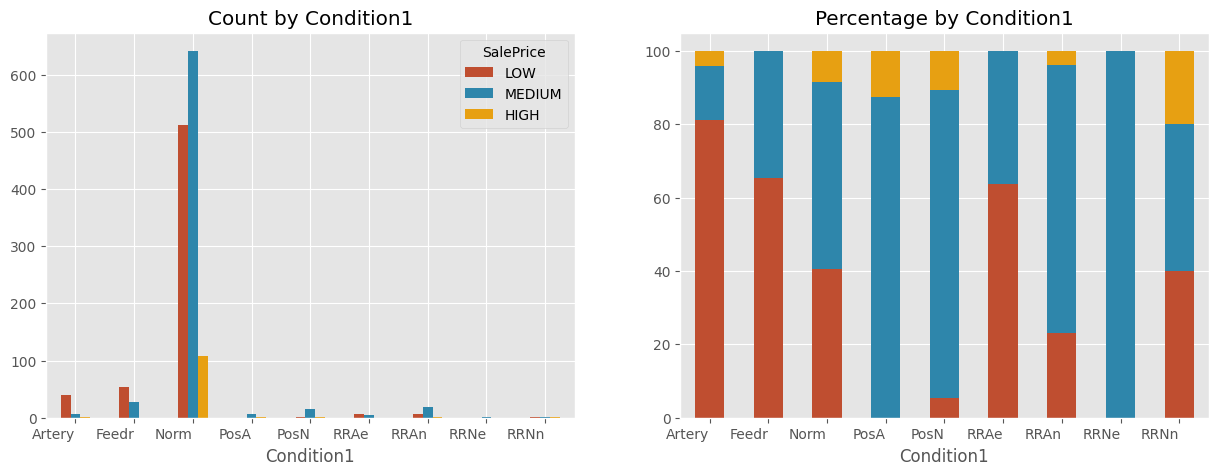

In [41]:
#The values for this attribute are strongly unbalanced among the categories inside the training set.
#As we can see from the barplot with percentages there is not a marked trend.
category_common_analysis(data=df, x='Condition1',target='SalePrice', palette=palette)

#### Condition2

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


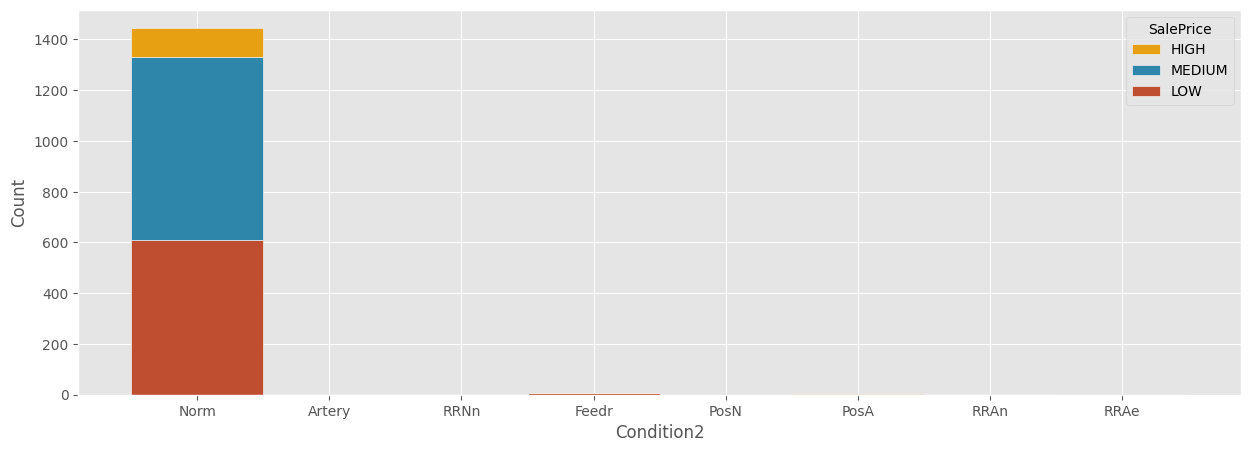

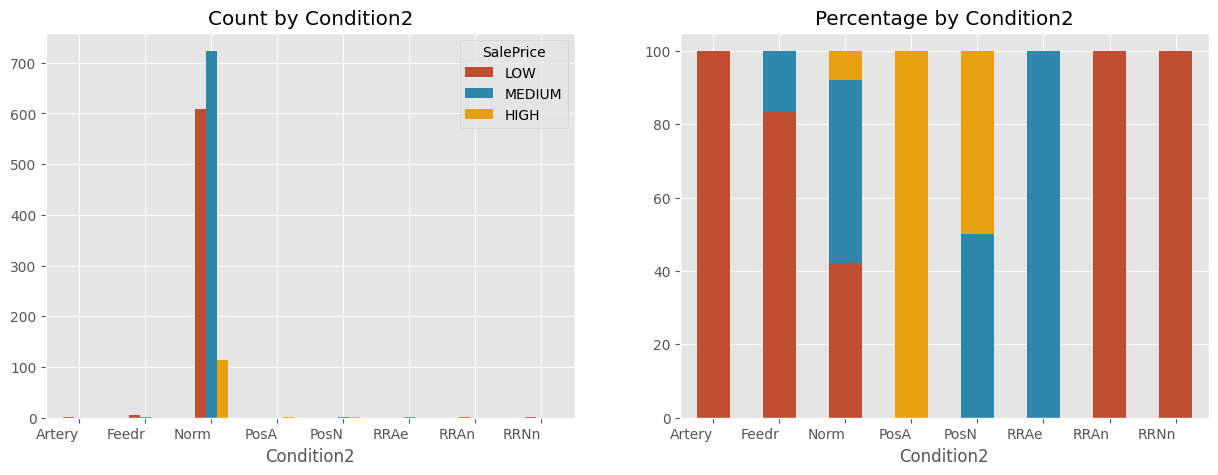

In [42]:
# Same reasoning as for Condition1
category_common_analysis(data=df, x='Condition2',target='SalePrice', palette=palette)

#### BldgType

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64


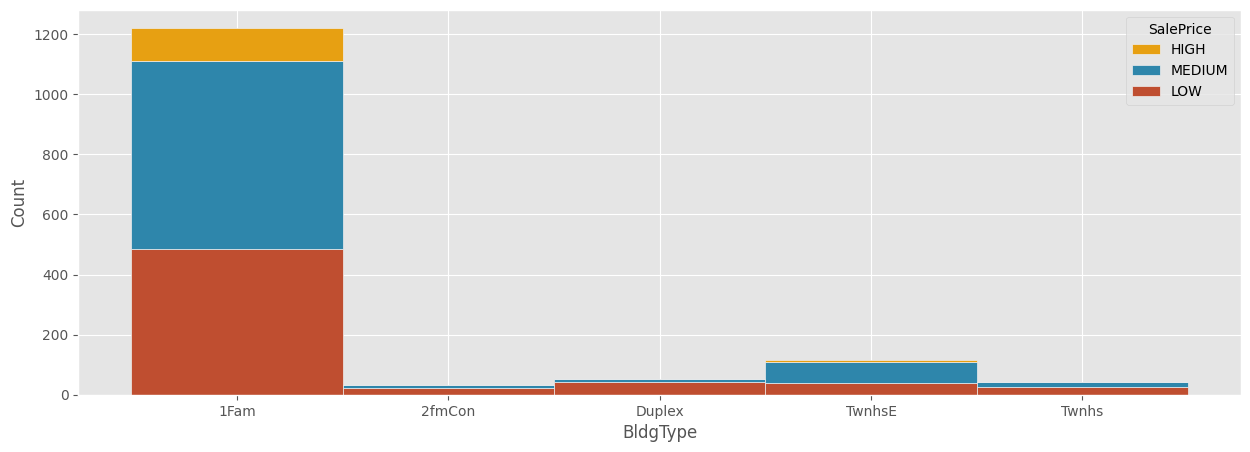

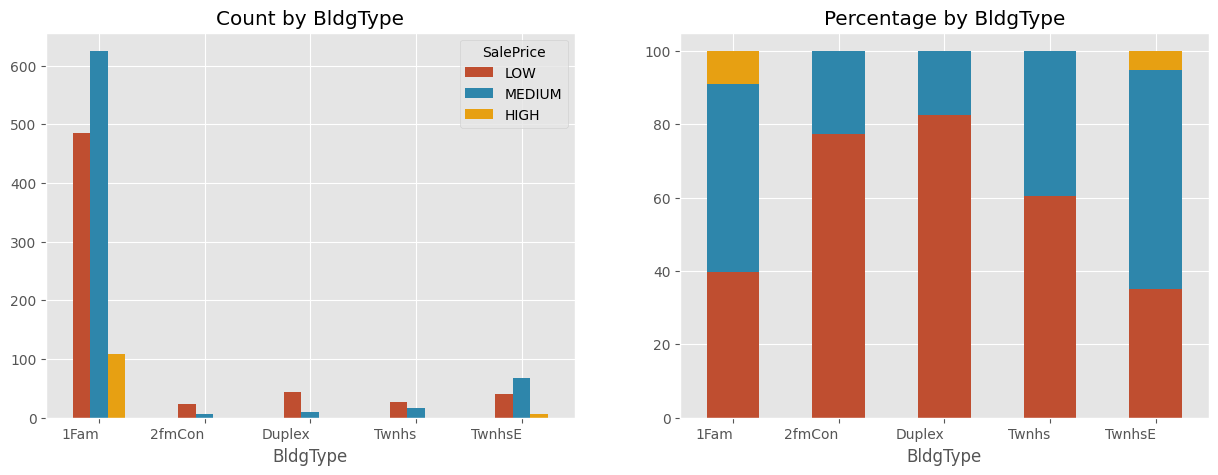

In [43]:
category_common_analysis(data=df, x='BldgType',target='SalePrice', palette=palette)

#### HouseStyle

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64


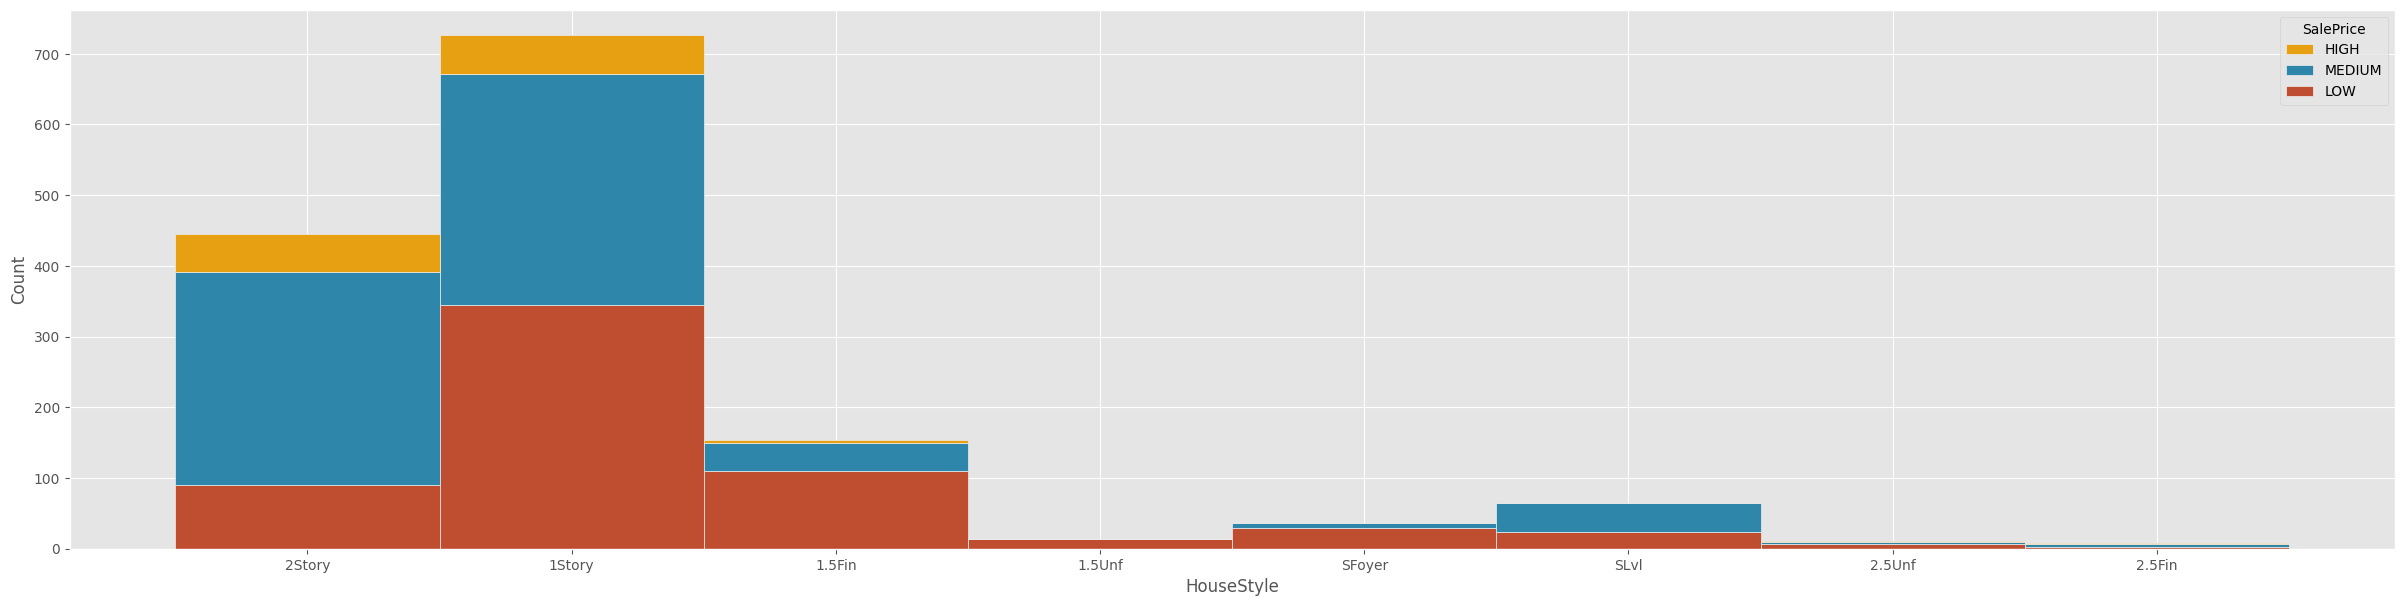

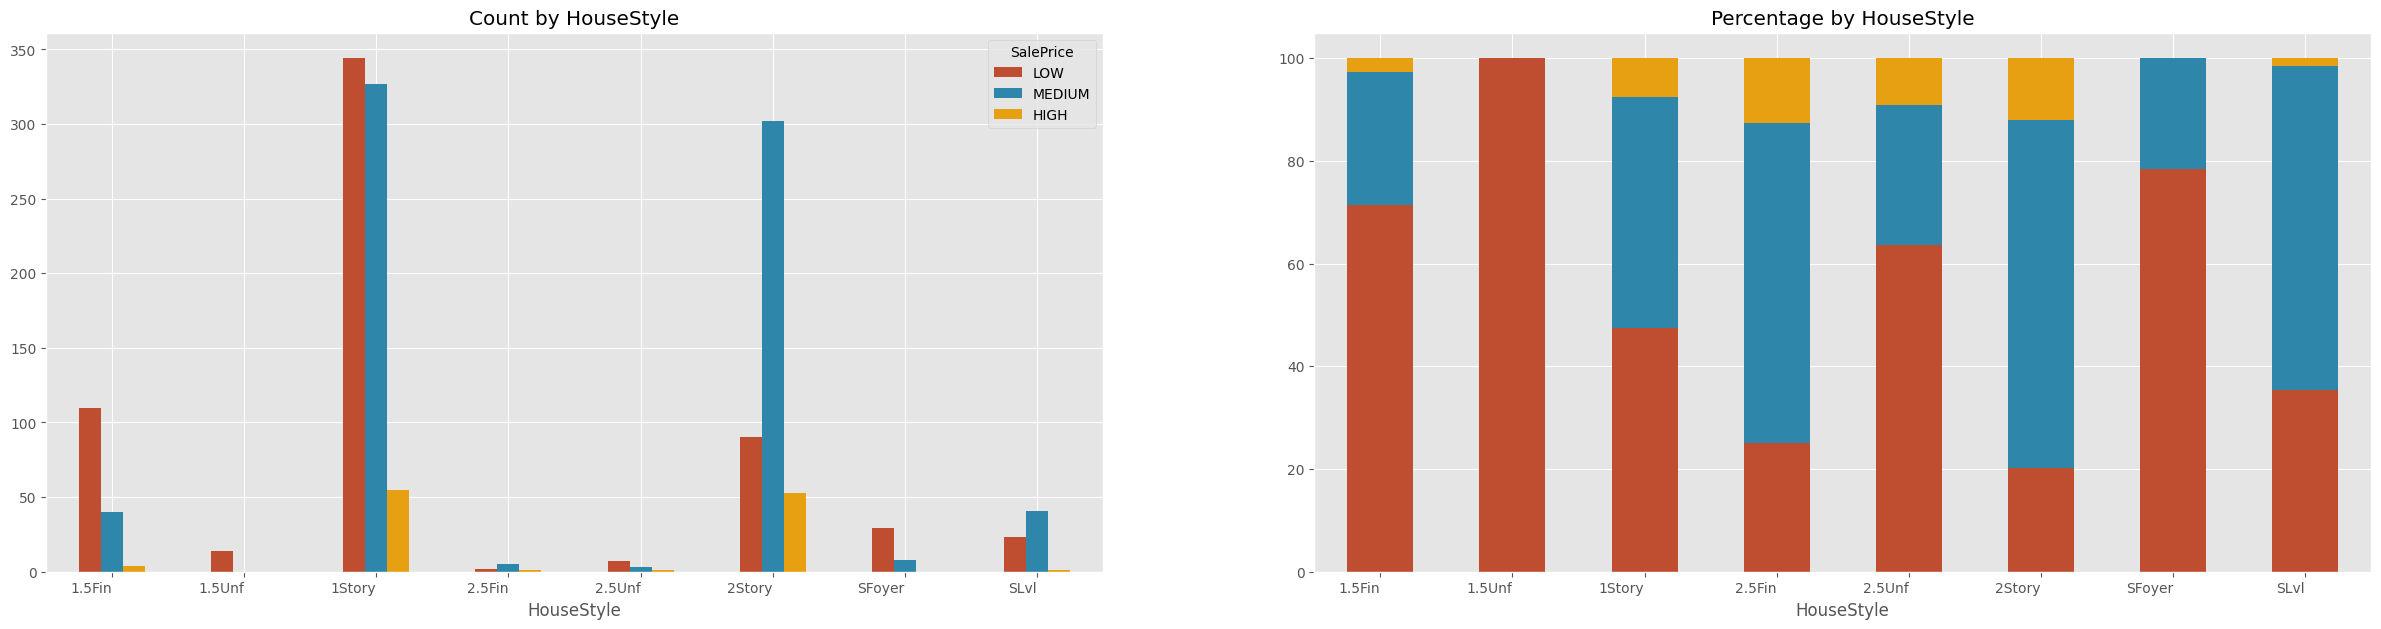

In [44]:
#As we can see from the plots here there is a significant correlation between the style of the house and the price.
#In particular, as the number of floors increases the SalePrice also increases
category_common_analysis(data=df, x='HouseStyle',target='SalePrice', palette=palette, figsize=(30,7))

#### OverallQual

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64


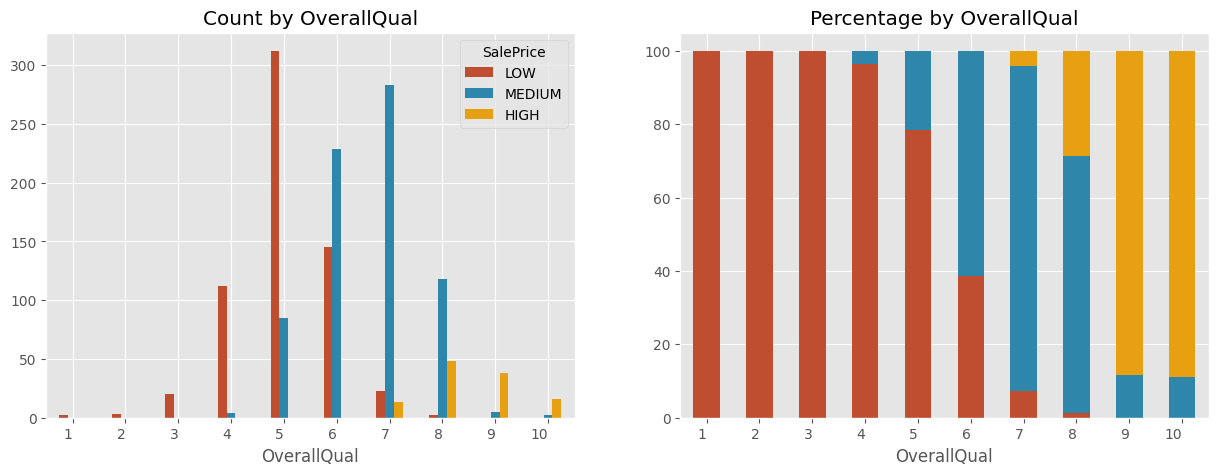

In [45]:
#In this case the trend is evident: the higher the overall quality of the house the higher the sale price
print(df['OverallQual'].value_counts())
frequencies_and_percentages(df, 'SalePrice', 'OverallQual')

#### OverallCond

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64


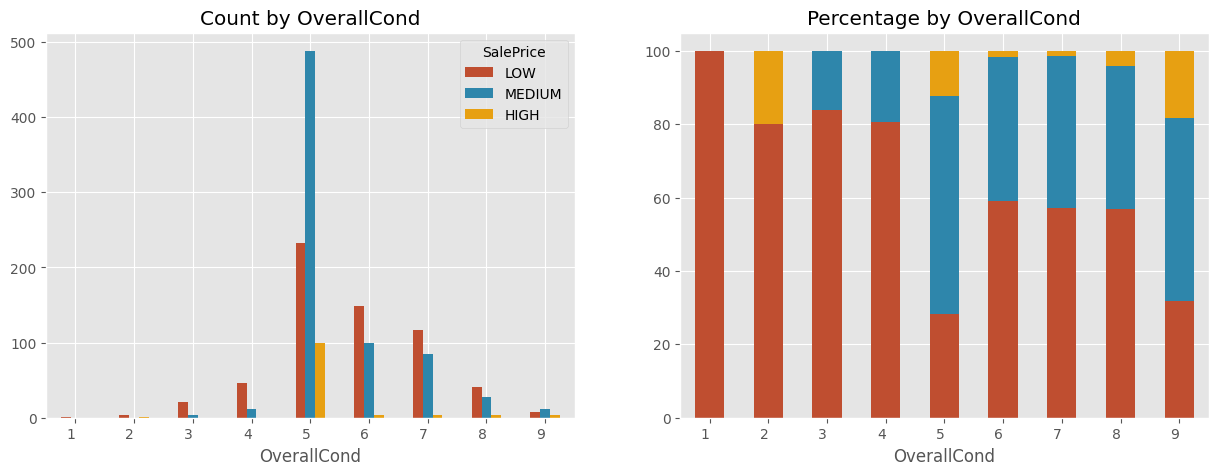

In [46]:
#In this case the trend is not so marked and probably is conditioned by the fact that
#of the houses are spread across only three of the nine possible values for this attribute
frequencies_and_percentages(df, 'SalePrice', 'OverallCond')
print(df['OverallQual'].value_counts())

#### YearBuilt

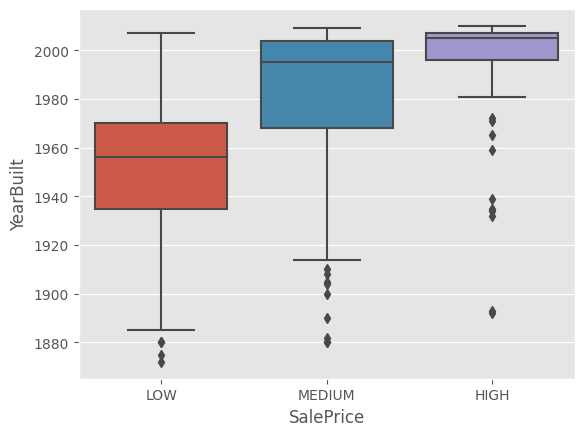

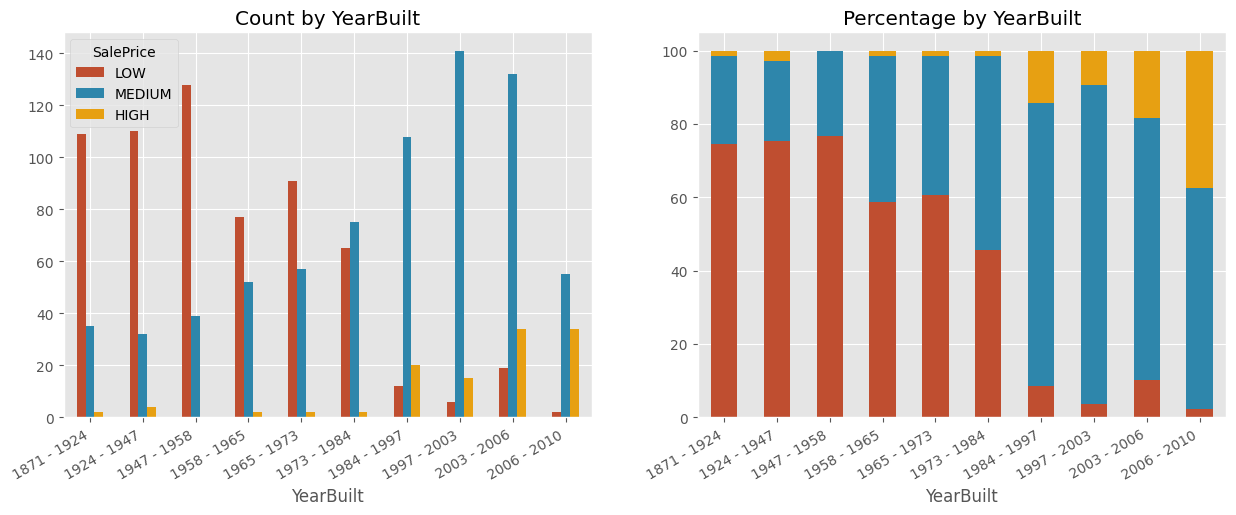

In [47]:
#As we can see, the older the house the lower the associated SalePrice.
#Moreover, for this attribute we do not have higly skewed or non uniform distribution like we had for several other attributes
sb.boxplot(data=df, y="YearBuilt", x="SalePrice")
frequencies_and_percentages_numeric(df, 'SalePrice', 'YearBuilt', rotation=30, bin=10)
#histplot(df,'SalePrice',"YearBuilt",alpha=0.5)

#### YearRemodAdd

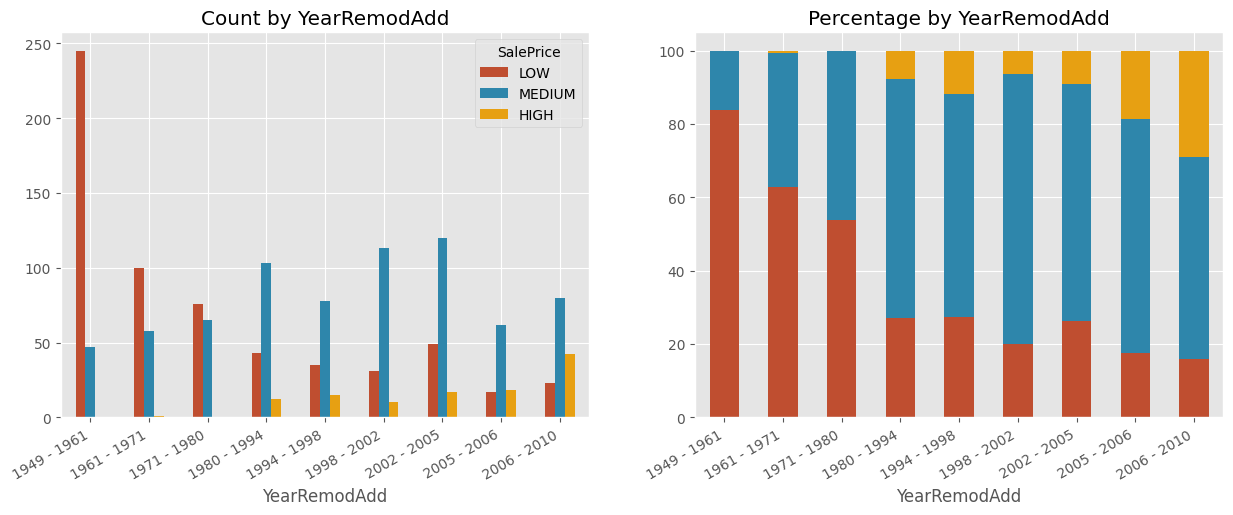

In [48]:

frequencies_and_percentages_numeric(df, 'SalePrice', 'YearRemodAdd', rotation=30, bin = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

#### RoofStyle

Gable    1141
Hip       286
Other      33
Name: RoofStyle, dtype: int64


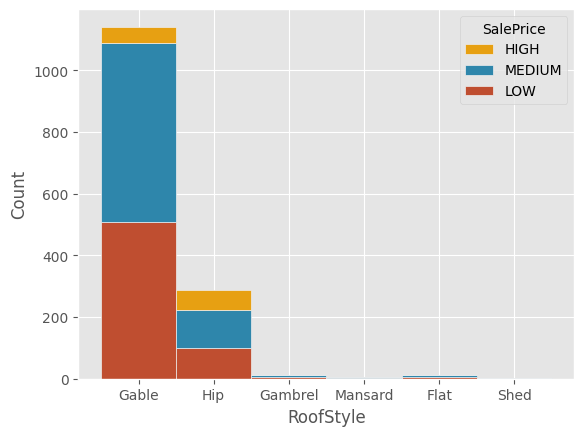

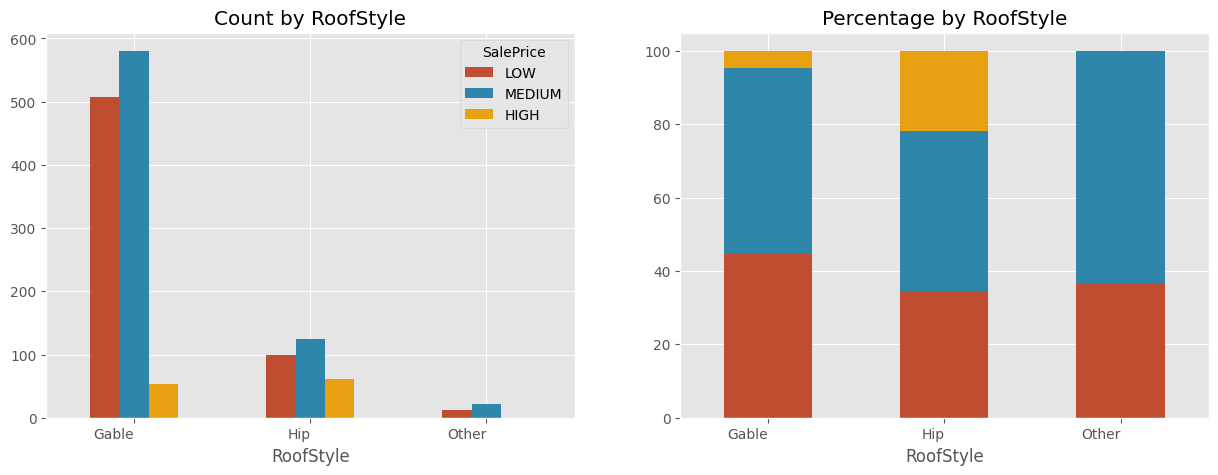

In [49]:
sb.histplot(x = df['RoofStyle'], multiple='stack', hue = df.SalePrice,  data = df['RoofStyle'], hue_order = hue_order, palette = palette, alpha=1)
category_common_analysis(data=aggregate(df = df.copy(), attribute='RoofStyle', new_name="Other", threshold=20), x='RoofStyle', histplot=False,target='SalePrice', palette=palette)

#### RoofMatl

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64


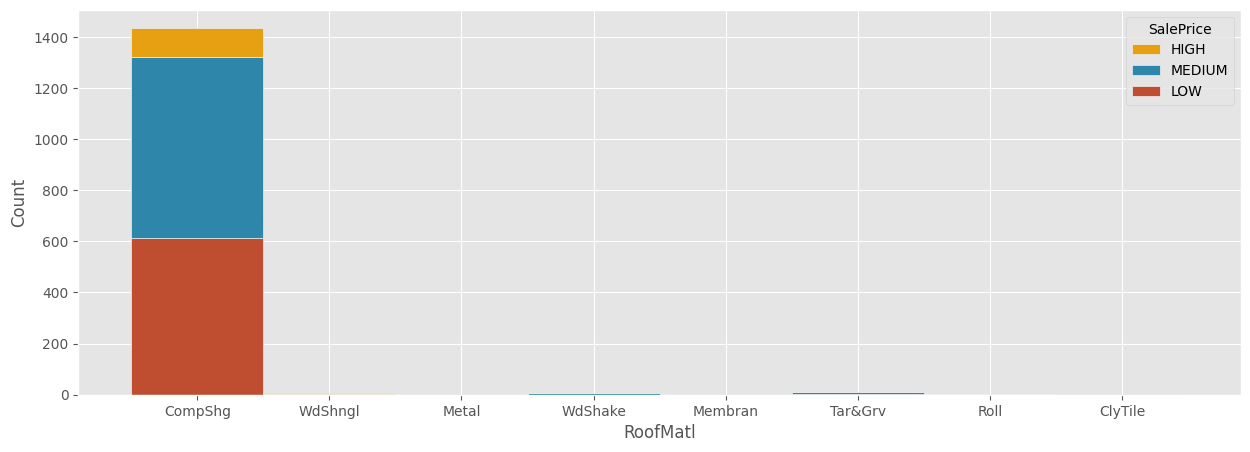

In [50]:
# Not useful
category_common_analysis(data=df, x='RoofMatl',target='SalePrice', percentages=False, palette=palette)

#### Exterior1st & Exterior2nd

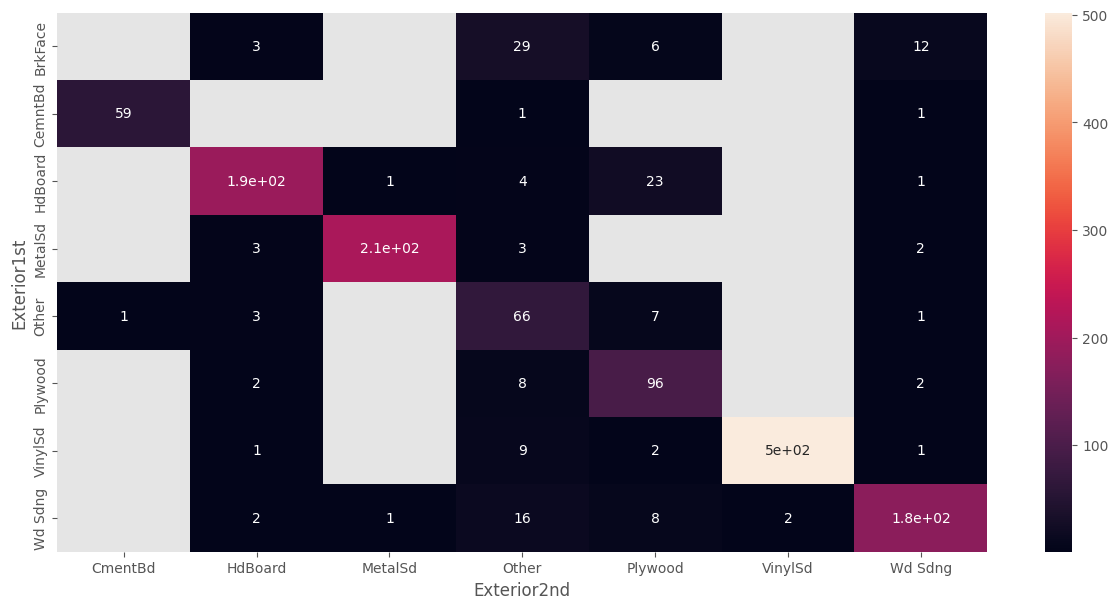

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
Other       78
CemntBd     61
BrkFace     50
Name: Exterior1st, dtype: int64
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
Other      136
CmentBd     60
Name: Exterior2nd, dtype: int64


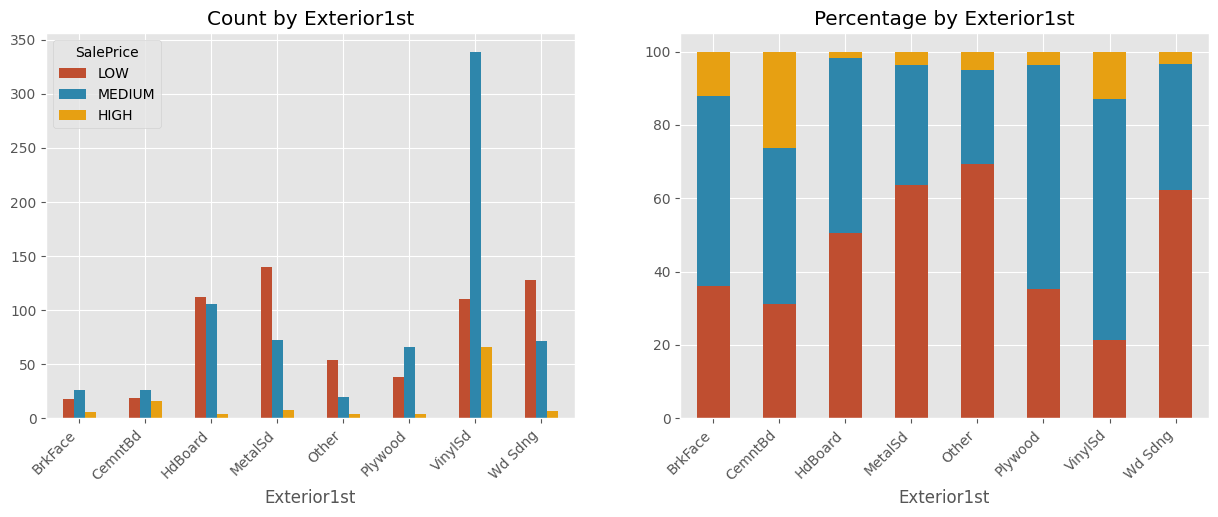

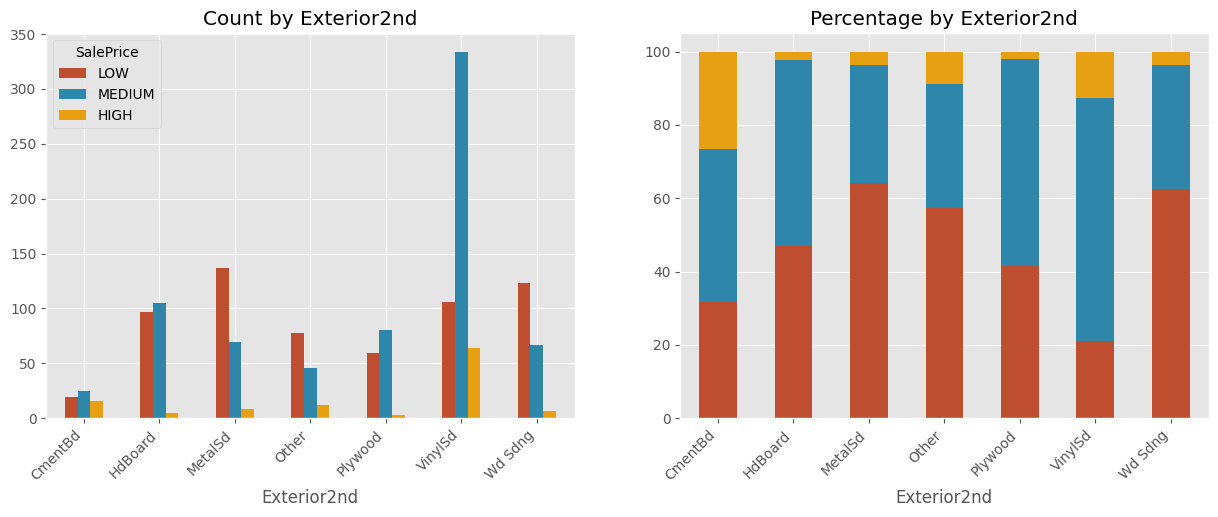

In [51]:
# sb.histplot(x = df["Exterior1st"], multiple='stack', hue = 'SalePrice',  data = df, hue_order = hue_order, palette = palette, alpha=1, ax=ax[0])
# sb.histplot(x = df["Exterior2nd"], multiple='stack', hue = 'SalePrice',  data = df, hue_order = hue_order, palette = palette, alpha=1, ax=ax[1])
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
# ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')

#Basically they are too similar to each other
df1 = aggregate(df=df.copy(), new_name="Other", threshold=40, attribute="Exterior1st")
df1 = aggregate(df=df1 , new_name="Other", threshold=40, attribute="Exterior2nd")
plt.figure(figsize = (15,7))
df_heatmap =  df1[['Exterior1st','Exterior2nd']].pivot_table(index='Exterior1st',columns='Exterior2nd',aggfunc=len)
sb.heatmap(df_heatmap,annot=True)
plt.show()
category_common_analysis(data=df1, x='Exterior1st',target='SalePrice', histplot=False, palette=palette,rotation=45, figsize=(15, 5))
category_common_analysis(data=df1, x='Exterior2nd',target='SalePrice', histplot=False, palette=palette,rotation=45, figsize=(15, 5))


#### MasVnrType

None       864
BrkFace    445
Stone      128
BrkCmn      15
NA           8
Name: MasVnrType, dtype: int64


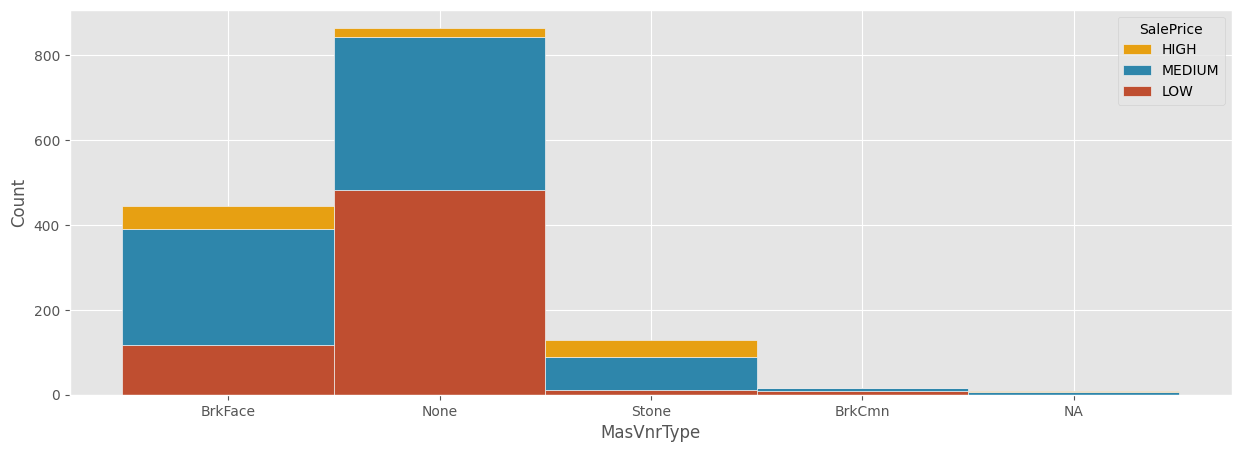

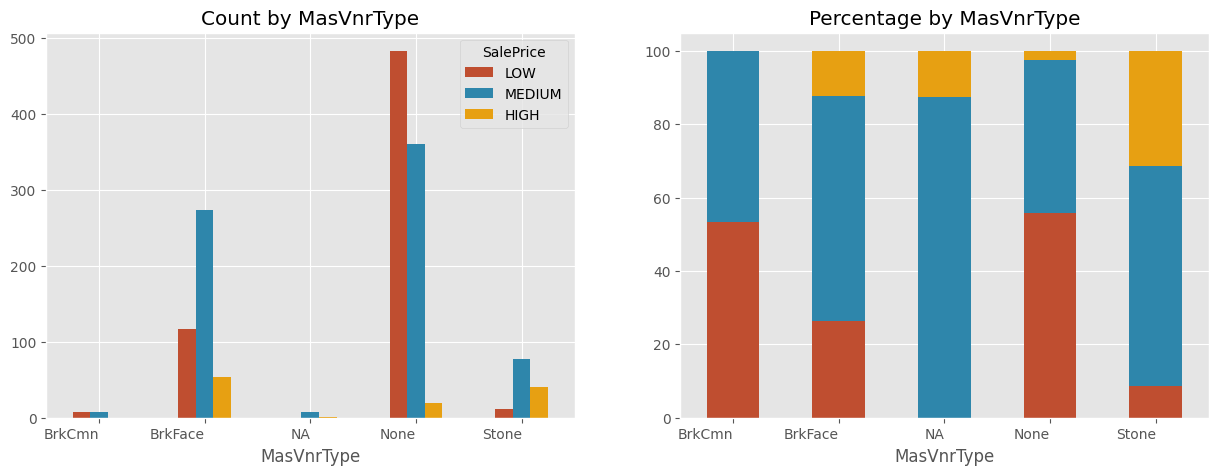

In [52]:
# Na are only 8 elements and they correspond to unknown
# Stone and None are significant respectively to High and Low
#We suggest to change the 8 elements with None, since they are very few
category_common_analysis(data=df, x='MasVnrType',target='SalePrice', percentages=True, palette=palette)

#### MasVnrArea

        Id MasVnrArea MasVnrType
234    235         NA         NA
529    530         NA         NA
650    651         NA         NA
936    937         NA         NA
973    974         NA         NA
977    978         NA         NA
1243  1244         NA         NA
1278  1279         NA         NA
Empty DataFrame
Columns: [Id, MasVnrArea, MasVnrType]
Index: []
Empty DataFrame
Columns: [Id, MasVnrArea, MasVnrType]
Index: []


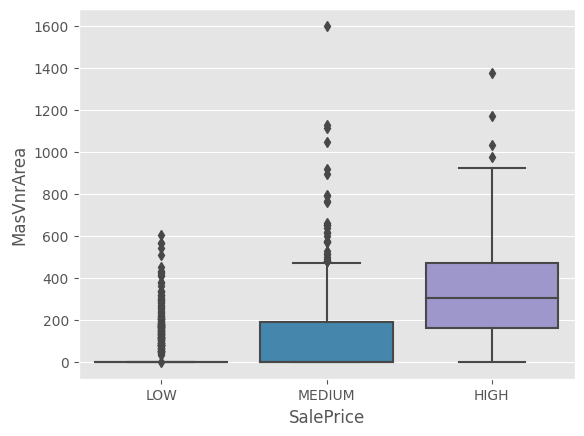

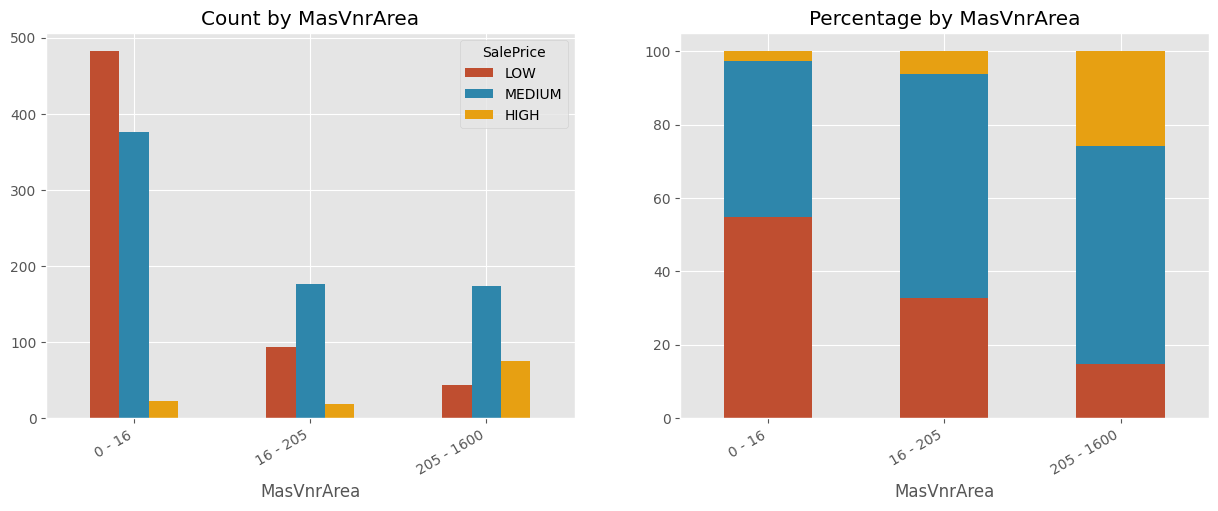

In [53]:
#The 8 NA values of MasVnrType have no Mas, then also this is Na, we can insert 0 (without changing the original data frame)
#by default in order to understand better the data
#We thing that the interaction between MasVnrType and MasVnrArea could be relevant
#We change the type to numeric
df1 = df.copy()
print(df1[df1["MasVnrArea"]  == "NA"][["Id","MasVnrArea","MasVnrType"]])
for i,e in df1.iterrows():
    if e["MasVnrArea"]=="NA":
        df1.at[i, "MasVnrArea"] = 0
print(df1[df1["MasVnrArea"]  == "NA"][["Id","MasVnrArea","MasVnrType"]])
df1["MasVnrArea"] = df1["MasVnrArea"].astype("int64")
print(df1[df1["MasVnrArea"]  < 0][["Id","MasVnrArea","MasVnrType"]])
sb.boxplot(data=df1, y="MasVnrArea", x="SalePrice")
frequencies_and_percentages_numeric(df1, 'SalePrice', 'MasVnrArea', rotation=30, bin=[0, 0.6, 0.8, 1])


#### ExterQual & ExterCond

#### ExterQual

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64


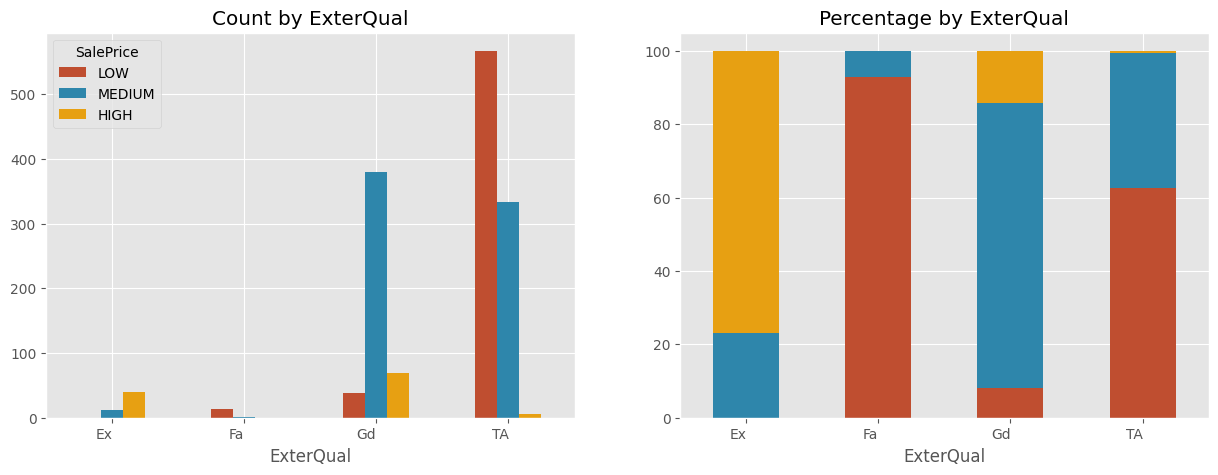

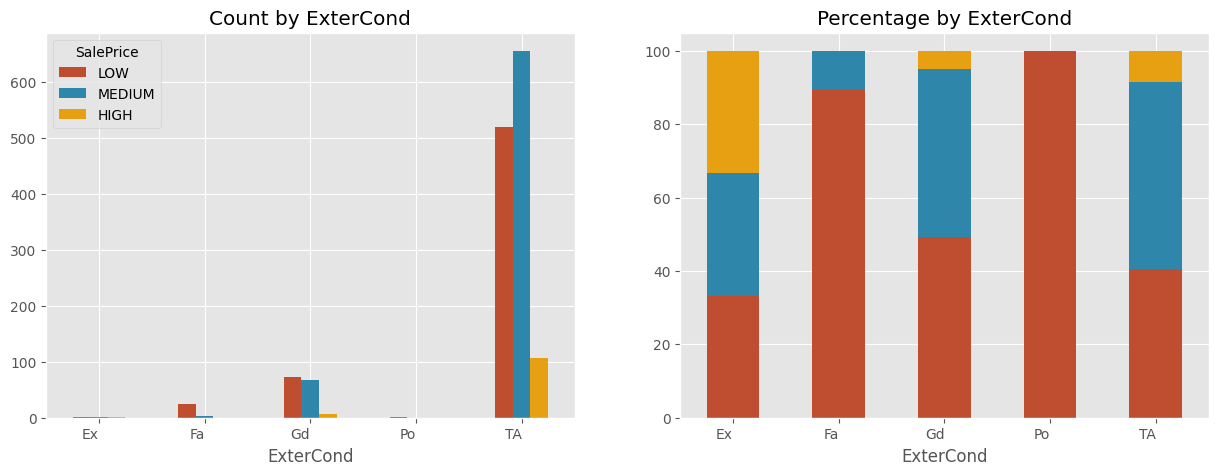

In [54]:
category_common_analysis(data=df, x='ExterQual',target='SalePrice', histplot=False, palette=palette)
category_common_analysis(data=df, x='ExterCond',target='SalePrice', histplot=False, palette=palette)

#### Foundation

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64


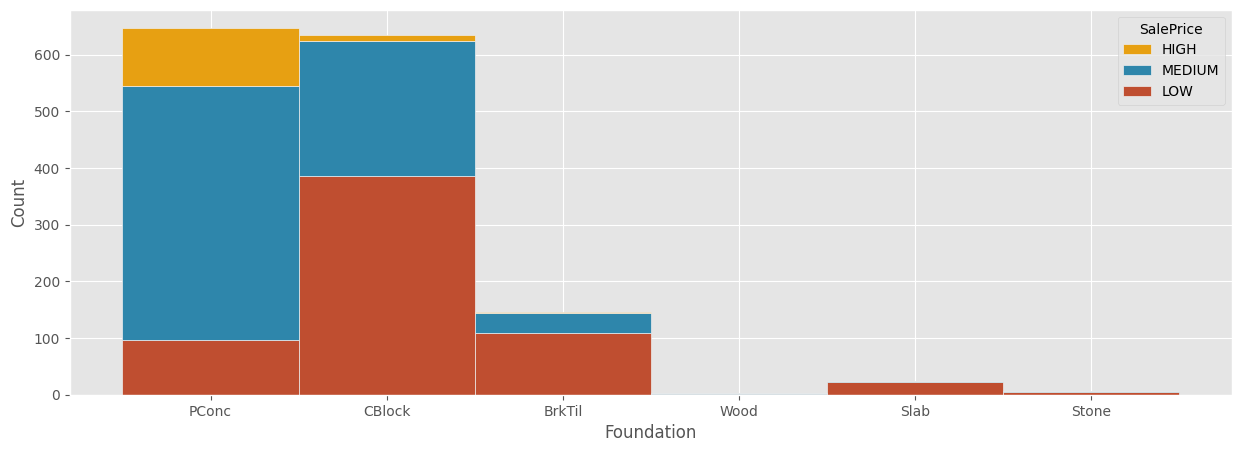

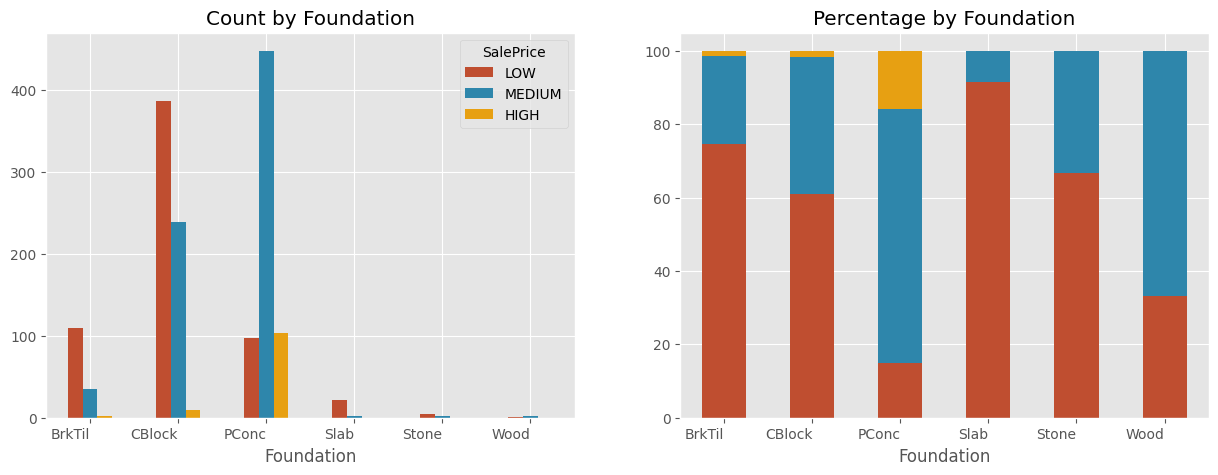

In [55]:
#insert other for wood, slab and stone
category_common_analysis(data=df, x='Foundation',target='SalePrice', percentages=True, palette=palette)

#### BsmtQual

TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: BsmtQual, dtype: int64


Ex    74
Gd    36
TA     5
Name: BsmtQual, dtype: int64

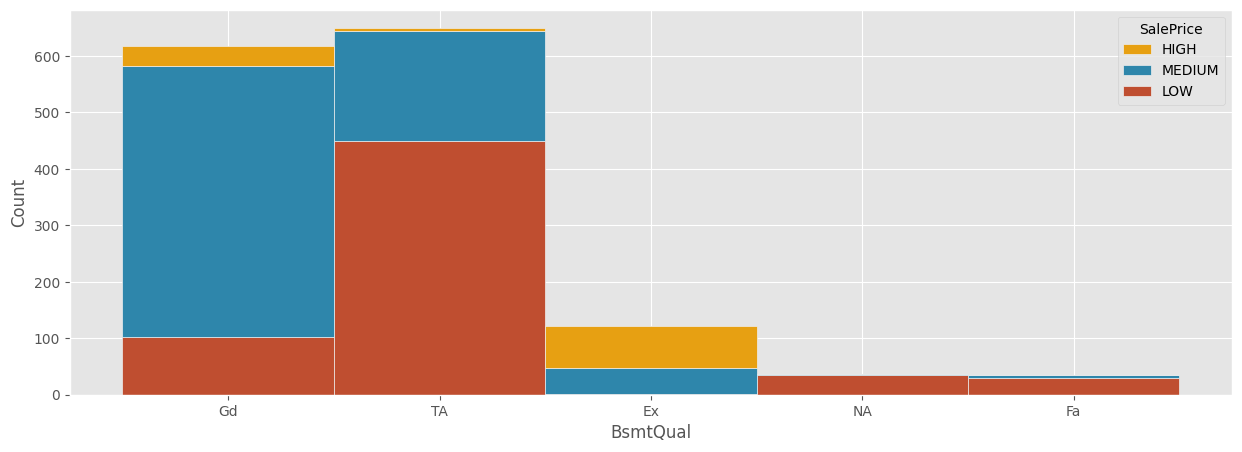

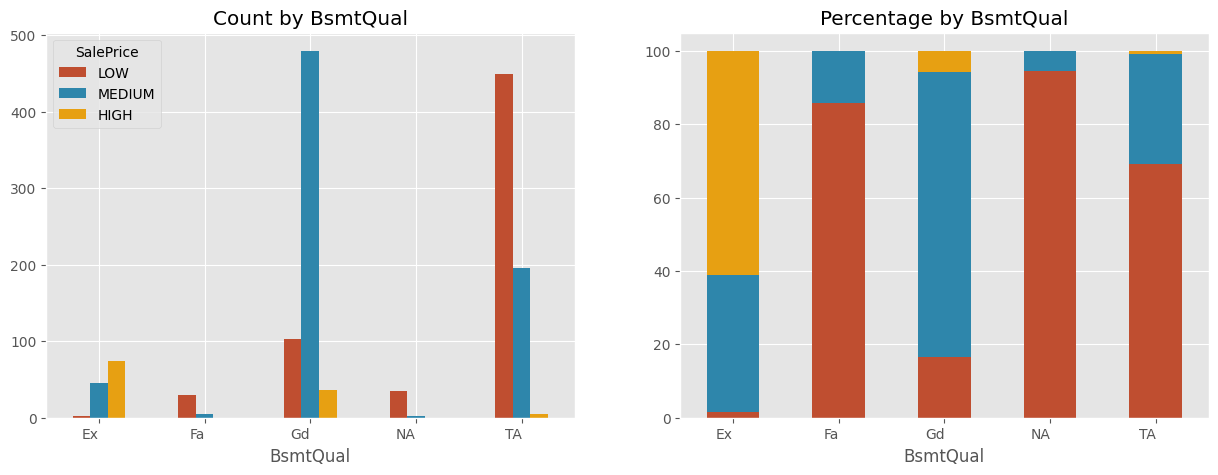

In [56]:
#insert other for wood, slab and stone
category_common_analysis(data=df, x='BsmtQual',target='SalePrice', percentages=True, palette=palette)
df[ (df["SalePrice"]=="HIGH")]["BsmtQual"].value_counts()

#### BsmtCond

TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: BsmtCond, dtype: int64


TA    107
Gd      8
Name: BsmtCond, dtype: int64

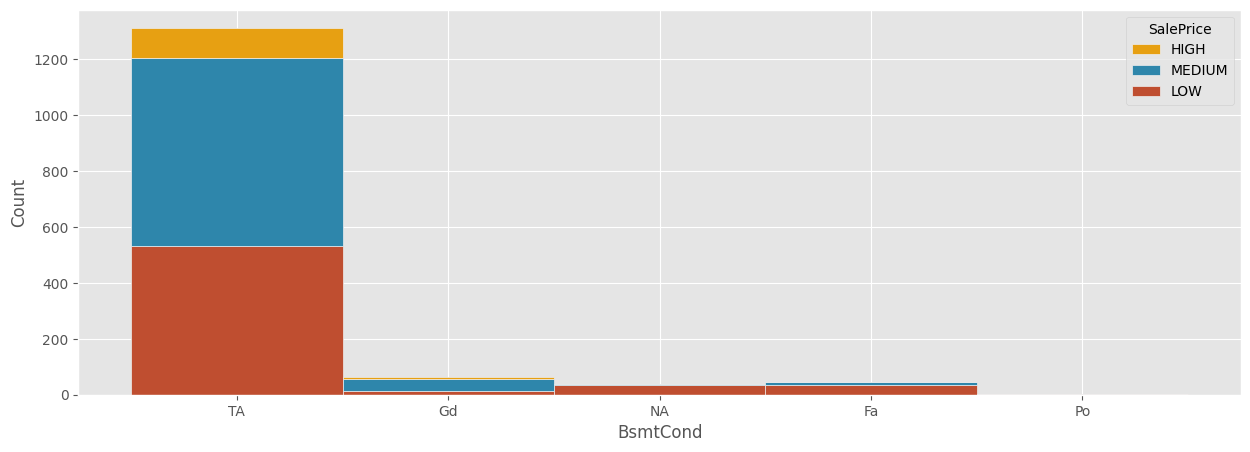

In [57]:
#Not useful, one element gather all the informations, too few elements for the other classes
category_common_analysis(data=df, x='BsmtCond',target='SalePrice', percentages=False, palette=palette)
df[ (df["SalePrice"]=="HIGH")]["BsmtCond"].value_counts()

#### BsmtExposure

SalePrice     LOW  MEDIUM  HIGH
BsmtExposure                   
Av             66     126    29
Gd             23      71    40
Mn             36      67    11
NA             35       3     0
No            459     459    35


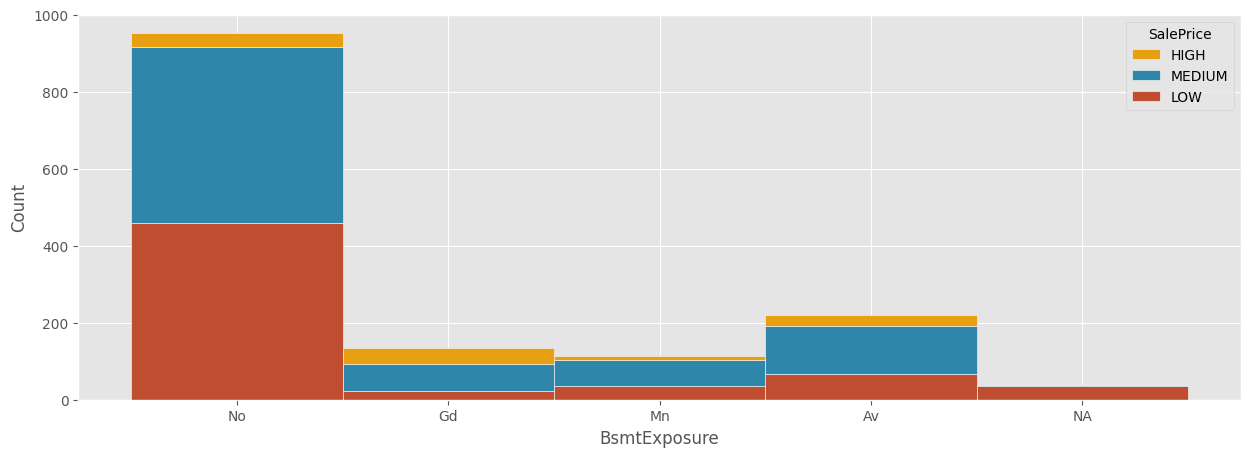

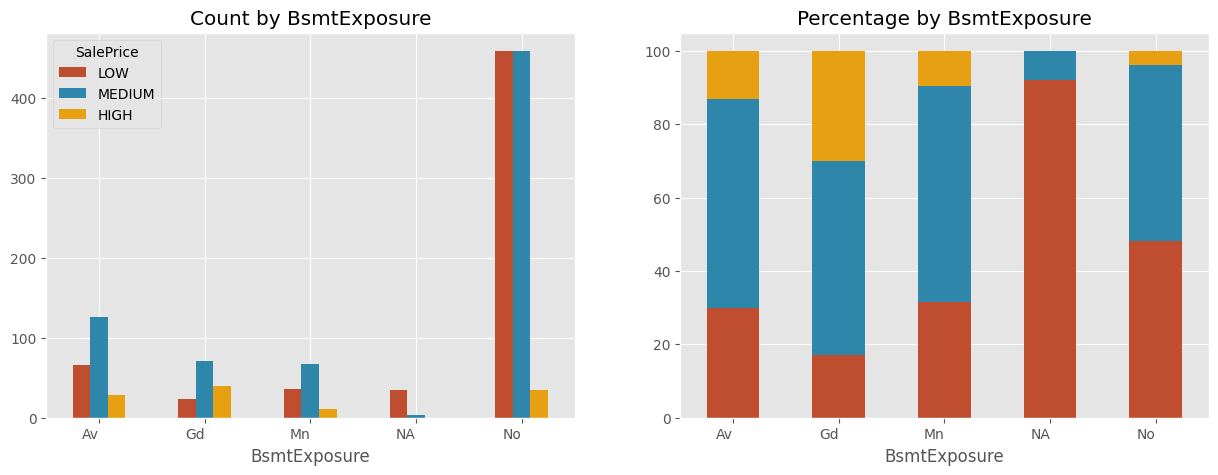

In [58]:

print(df[["BsmtExposure","SalePrice"]].pivot_table(index = "BsmtExposure" , columns=["SalePrice"],  aggfunc=len, fill_value=0))
category_common_analysis(data=df,x='BsmtExposure', display= False, target='SalePrice', percentages=True, palette=palette)

#### BsmtFinType1

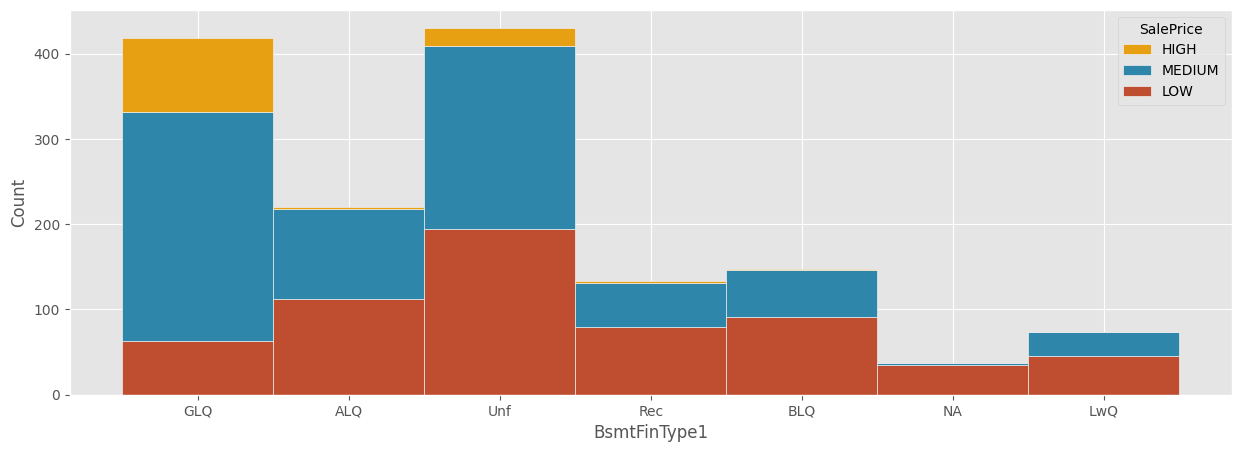

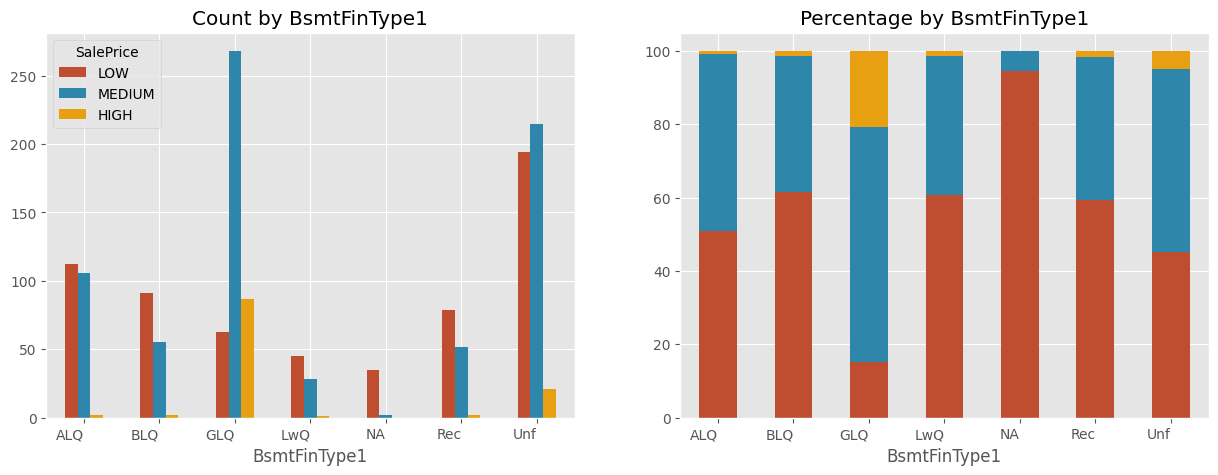

In [59]:

category_common_analysis(data=df,x='BsmtFinType1', display= False, target='SalePrice', percentages=True, palette=palette)

#### BsmtFinSF1

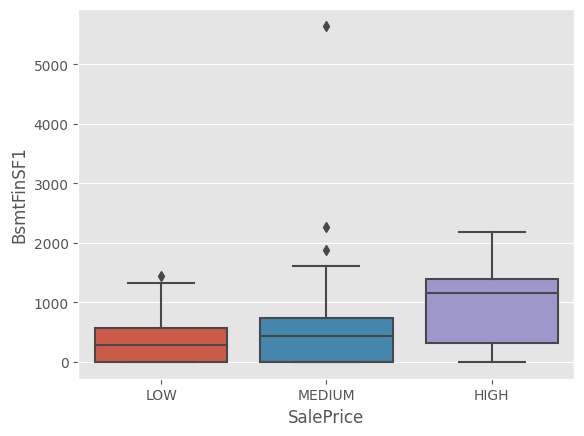

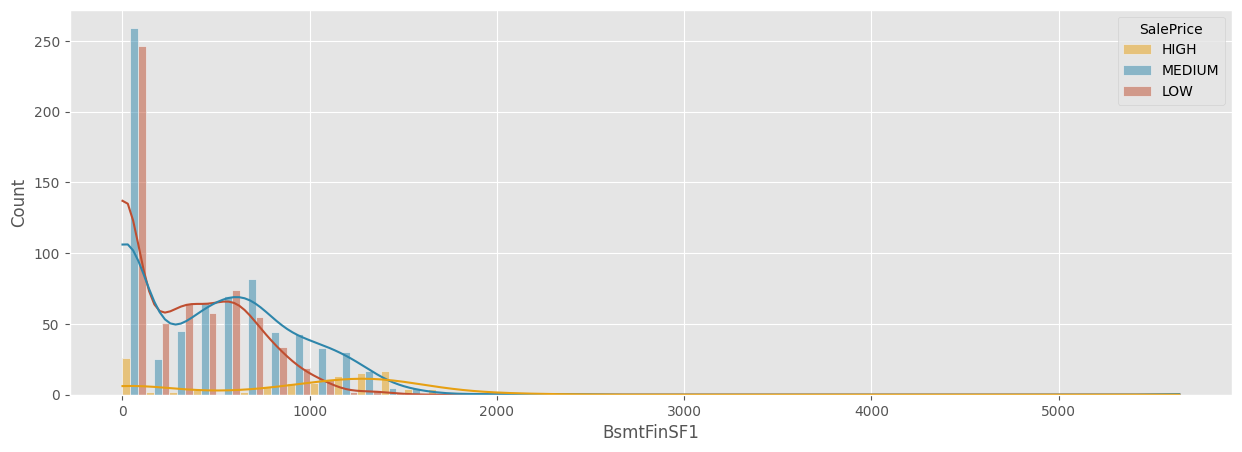

In [60]:

sb.boxplot(data=df, y="BsmtFinSF1", x="SalePrice")
histplot(df,'SalePrice',"BsmtFinSF1",multiple='dodge',alpha=0.5)

#### BsmtFinType2

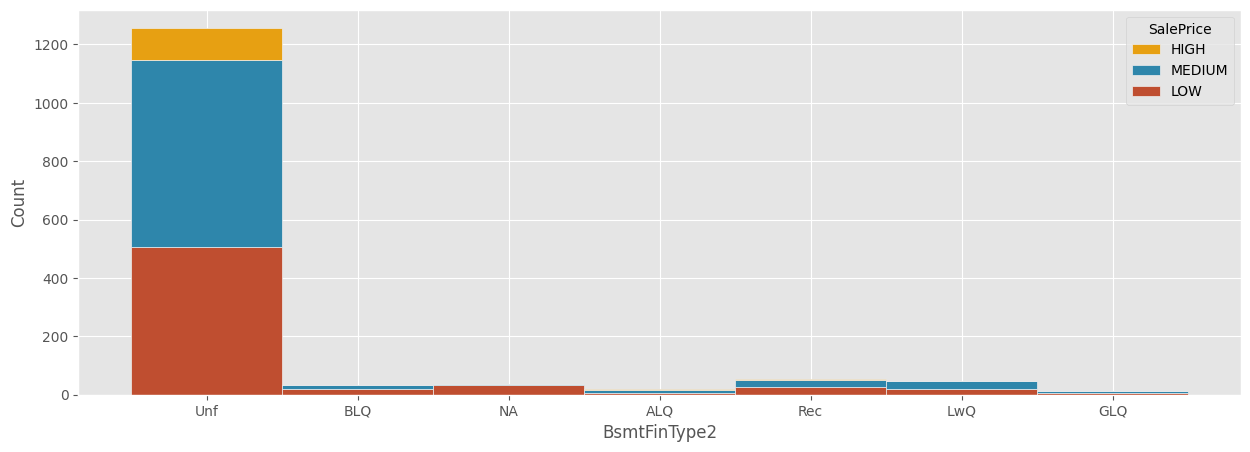

In [61]:
category_common_analysis(data=df,x='BsmtFinType2', display= False, target='SalePrice', percentages=False, palette=palette)

#### BsmtFinSF2

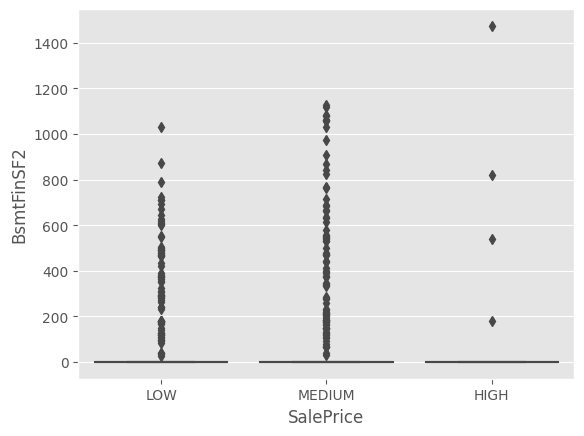

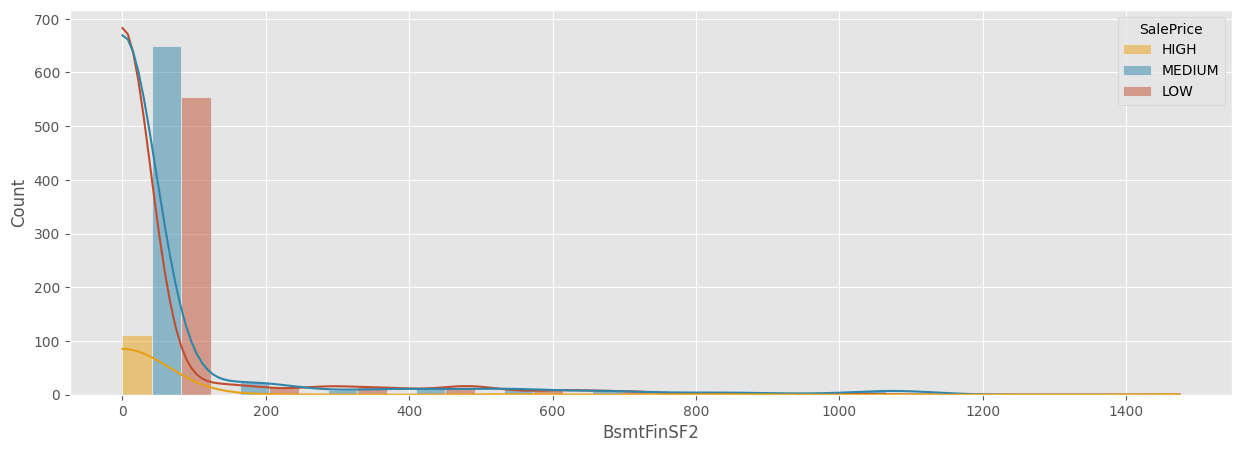

In [62]:
# as we can see from the boxplot all the means are approximately zero and also within the narrow range of plausible values
# no trend emerges
sb.boxplot(data=df, y="BsmtFinSF2", x="SalePrice")
histplot(df,'SalePrice',"BsmtFinSF2",multiple='dodge',alpha=0.5)

#### BsmtUnfSF

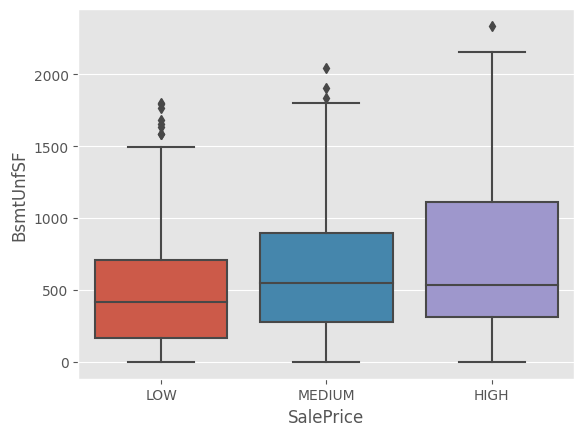

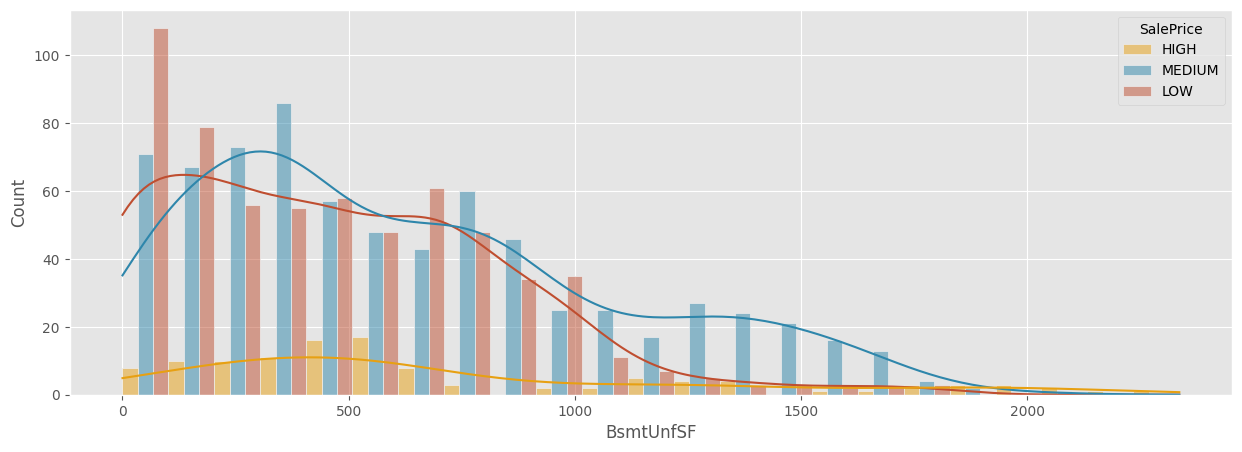

In [63]:
# The mean of the attribute is approximately equal for the MEDIUM and HIGH class, while for LOW it is smaller.
# However, the distributions of the three lables have almost the same peak
sb.boxplot(data=df, y="BsmtUnfSF", x="SalePrice")
histplot(df,'SalePrice',"BsmtUnfSF",multiple='dodge',alpha=0.5)
#frequencies_and_percentages_numeric(df, 'SalePrice', 'BsmtUnfSF', rotation=30, bin = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

#### TotalBsmtSF

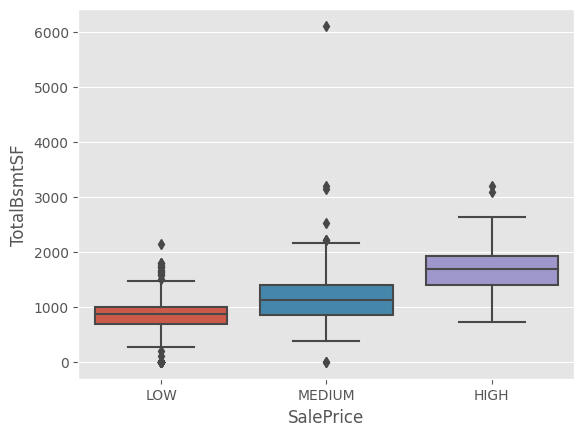

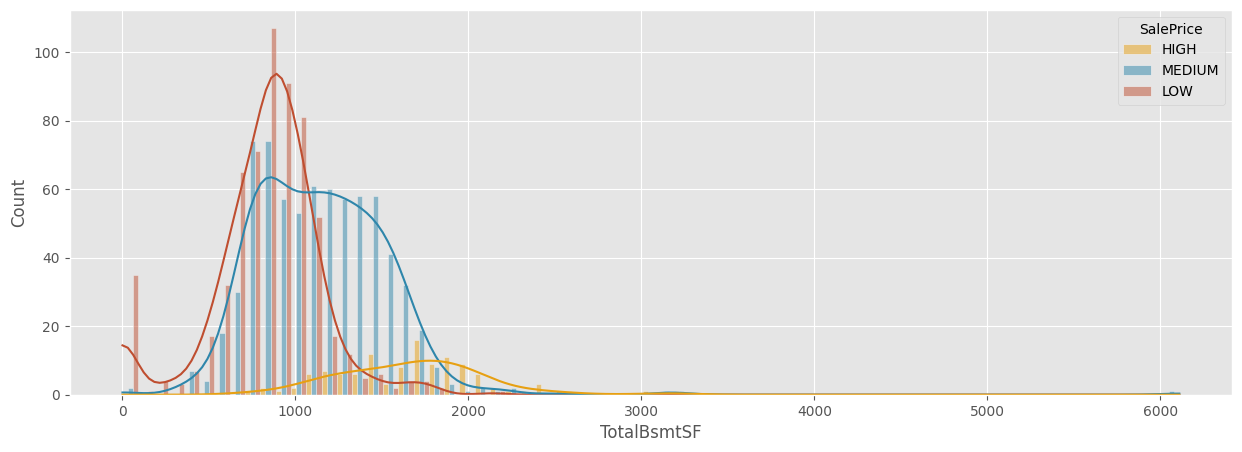

In [64]:
# The mean is different for all the three labels and the distributions of the labels
# look enough distant one from the other, so we keep the attribute
sb.boxplot(data=df, y="TotalBsmtSF", x="SalePrice")
histplot(df,'SalePrice',"TotalBsmtSF",multiple='dodge',alpha=0.5)

#### Heating

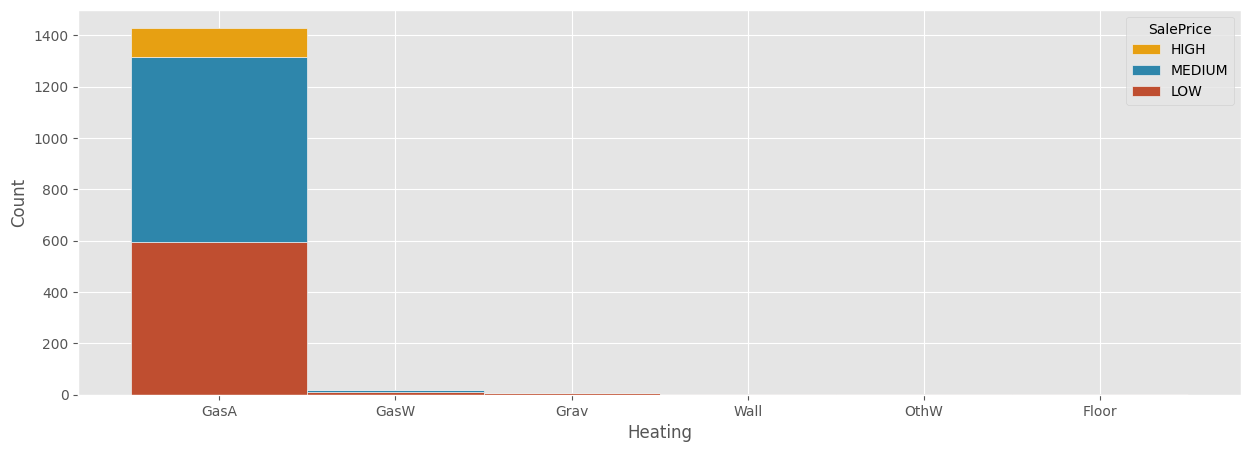

In [65]:
# Almost all the examples have the same attribute value, there is no use in keeping it 
category_common_analysis(data=df,x='Heating', display= False, target='SalePrice', percentages=False, palette=palette)

#### HeatingQC

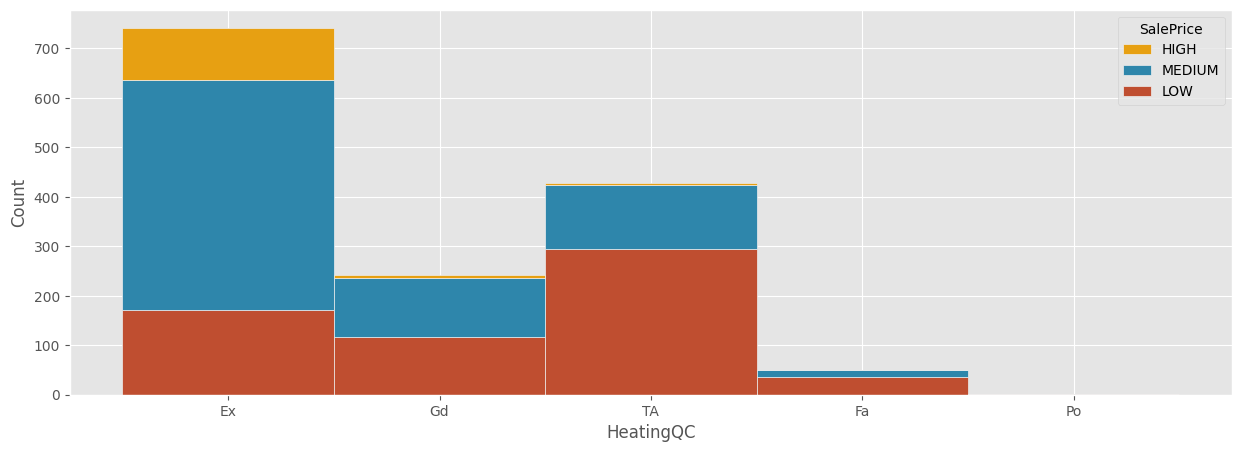

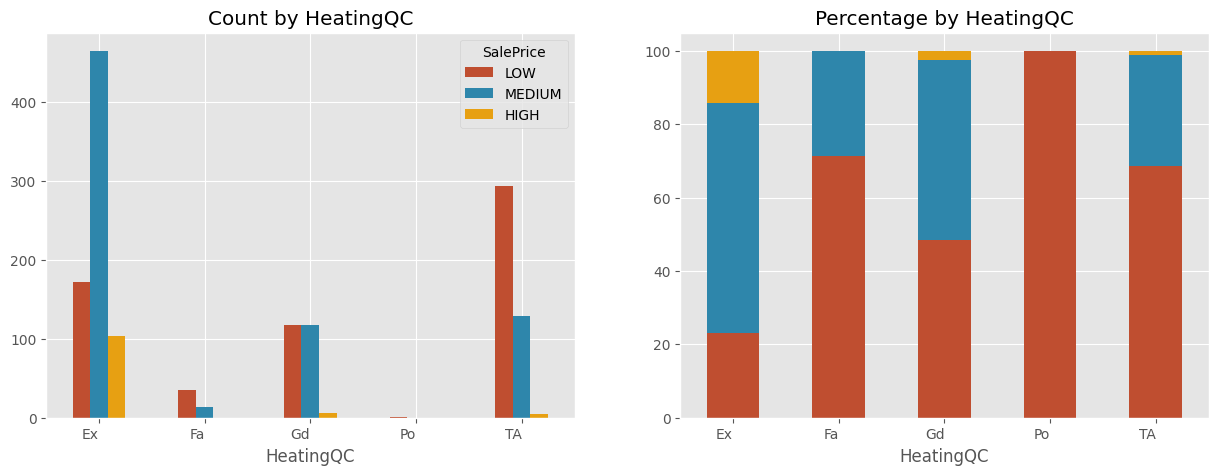

In [66]:

category_common_analysis(data=df,x='HeatingQC', display= False, target='SalePrice', percentages=True, palette=palette)

### Correlation & statistic tests

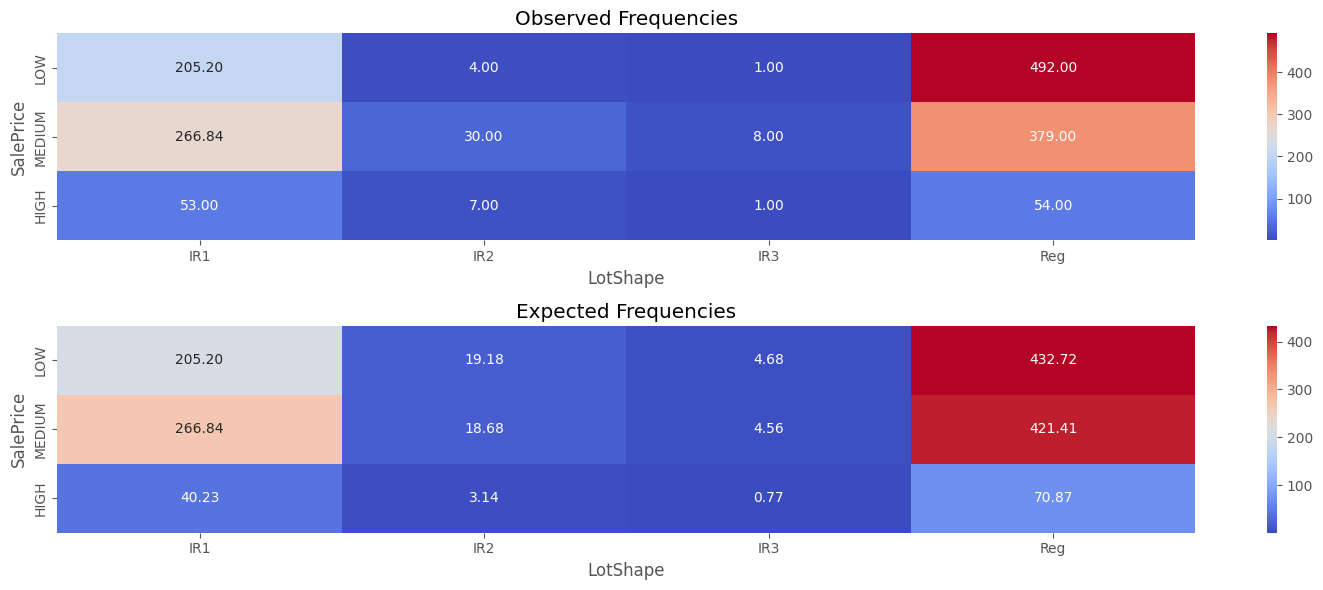

Chi-square Test - Outcome
P-Value: 5.252128283563737e-25 [<0.05]


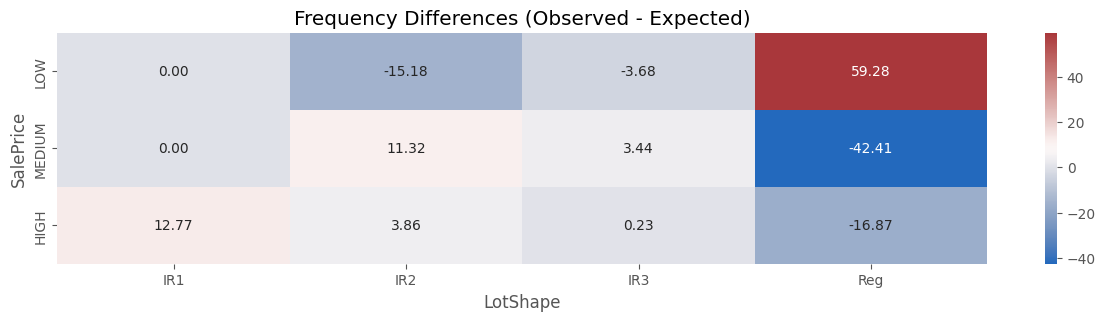

In [67]:
stattest_quali(df, 'LotShape')

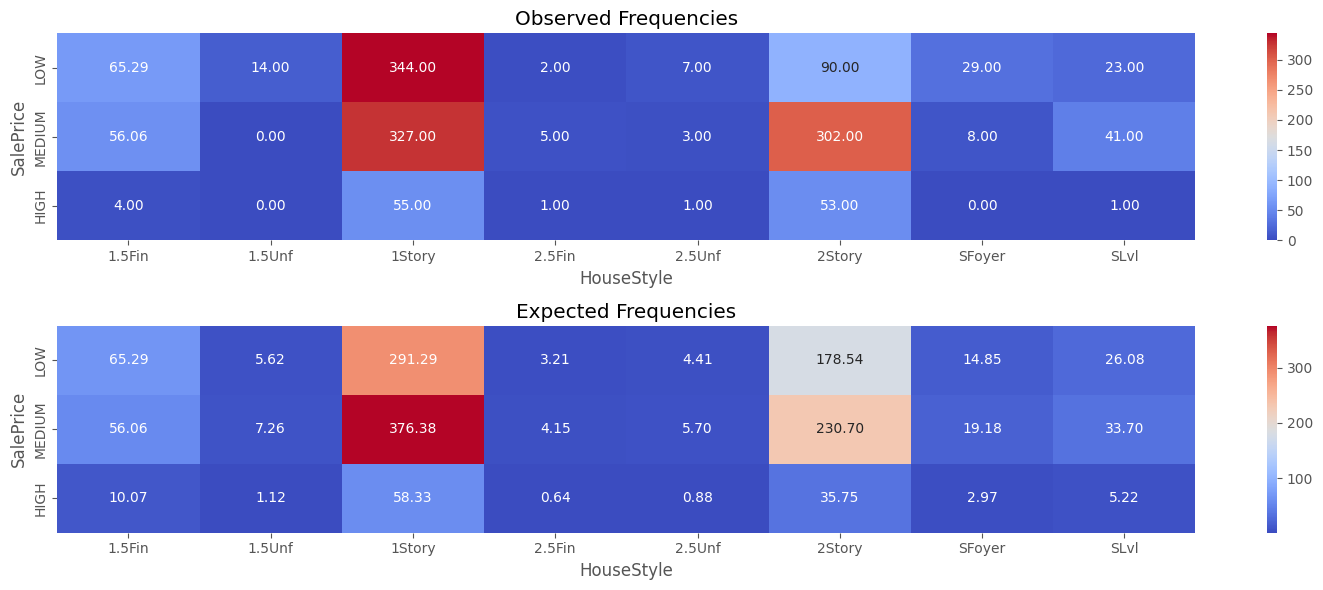

Chi-square Test - Outcome
P-Value: 5.042764923498675e-35 [<0.05]


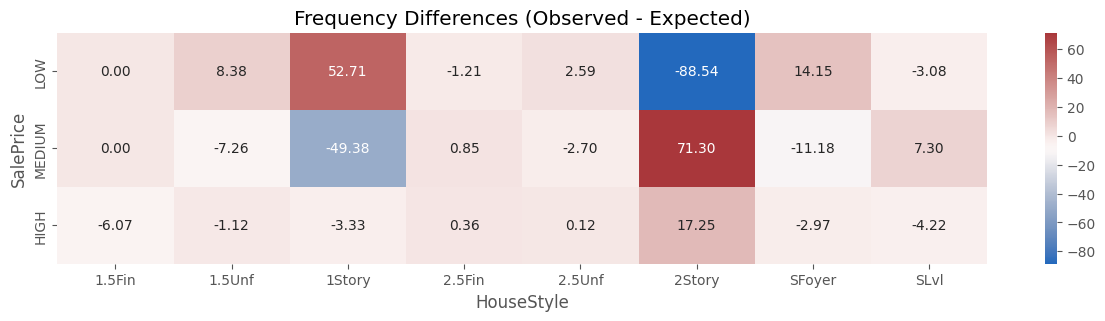

In [68]:
stattest_quali(df, 'HouseStyle')

In [69]:
# for col in df.columns:
#     if df[col].dtype == "object":
#         stattest_quali(df, col)

In [70]:
# for col in df.columns:
#     if df[col].dtype == "int":
#         stattest_quanti(df,col, 'SalePrice' , low_limit=1900, upper_limit=2023)

In [71]:
# sb.pairplot(df, hue = 'SalePrice')
# plt.show()

#### Results

| Attribute                     | Description                                                                                   |
|------------------------------	|----------------------------------------------	                                                |
| ID                        	| Maximum entropy and not correlated  with the target attribute, removed                        |
| Age               	        | Good correlation with values: DrugA and DrugB of the target attribute 	                    |
| Sex                    	    | Seems to not influence the target attribute, low IG, may be removed     	                    |
| BP                	        | Good predictor, it influences the target attribute                                            |
| Cholesterol           	    | Good predictor, it influences two attribute value of the target attribute: DrugX and DrugC    |
| Na                            | Good predictor                              	                                                |
| K 	                        | Good predictor 	                                                                            |
| Drug            	            | Class label                              	                                                |

### **Data Preparation**

#### Remove null values

In [72]:
df.dropna(inplace = True)
df.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
salePriceNum     0
Length: 82, dtype: int64

#### Remove attributes

In [73]:
df.drop(columns=['ID'], inplace = True)
df_ws = df.drop(columns=['Sex'])

KeyError: "['ID'] not found in axis"

#### Set type category

In [ ]:
df["Sex"] = df["Sex"].astype("category")
df["BP"] = df["BP"].astype("category")
df["Cholesterol"] = df["Cholesterol"].astype("category")
df["Drug"] = df["Drug"].astype("category")


df_ws["BP"] = df["BP"].astype("category")
df_ws["Cholesterol"] = df["Cholesterol"].astype("category")
df_ws["Drug"] = df["Drug"].astype("category")

#### Binarization

In [ ]:
# DF 
cat_attributes = list(df.select_dtypes(include = ['category']).columns)
cat_attributes.remove('Drug')
df_bin = pd.get_dummies(df, columns = cat_attributes)

## DF WS
cat_attributes = list(df_ws.select_dtypes(include = ['category']).columns)
cat_attributes.remove('Drug')
df_bin_ws = pd.get_dummies(df_ws, columns = cat_attributes)

df_bin.head()
df_bin_ws.head()

,Age,Na,K,Drug,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,0.792535,0.031258,drugY,1,0,0,1,0
1,47,0.739309,0.056468,drugC,0,1,0,1,0
2,47,0.697269,0.068944,drugC,0,1,0,1,0
3,28,0.563682,0.072289,drugX,0,0,1,1,0
4,61,0.559294,0.030998,drugY,0,1,0,1,0


### **Modeling**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

#### Creation of training, valuation and test sets

In [ ]:
seed = 101
test_size = .3
val_size = .2

# # DF 
# x = np.array(df.drop(columns="Drug").values)
# y = np.array(df['Drug'].values)

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)

# DF BIN 
x_bin = np.array(df_bin.drop(columns="Drug").values)
y_bin = np.array(df_bin['Drug'].values)

x_train_bin, x_test_bin, y_train_bin, y_test_bin = train_test_split(x_bin, y_bin, test_size=test_size, random_state=seed)
x_train_bin, x_val_bin, y_train_bin, y_val_bin = train_test_split(x_train_bin, y_train_bin, test_size=val_size, random_state=seed)


# DF WITHOUT SEX
x_bin_ws = np.array(df_bin_ws.drop(columns="Drug").values)
y_bin_ws = np.array(df_bin_ws['Drug'].values)

# DF BIN
x_train_bin_ws, x_test_bin_ws, y_train_bin_ws, y_test_bin_ws = train_test_split(x_bin_ws, y_bin_ws, test_size=test_size, random_state=seed)
x_train_bin_ws, x_val_bin_ws, y_train_bin_ws, y_val_bin_ws = train_test_split(x_train_bin_ws, y_train_bin_ws, test_size=val_size, random_state=seed)


#### Creation of models

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report

#### WITH SEX

In [ ]:
# models = []
# models.append(('C45', DecisionTreeClassifier(criterion='entropy', random_state=seed)))
# models.append(('CART', DecisionTreeClassifier(criterion='gini', random_state=seed)))
# models.append(('GaussianNaiveBayes', GaussianNB()))
# models.append(('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=500, verbose=True, 
#                                               random_state=seed)))

models_bin = []
models_bin.append(('C45', DecisionTreeClassifier(criterion='entropy', random_state=seed)))
models_bin.append(('CART', DecisionTreeClassifier(criterion='gini', random_state=seed)))
models_bin.append(('GaussianNaiveBayes', GaussianNB()))
models_bin.append(('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=500, verbose=True, 
                                              random_state=seed)))

for name, model_bin in models_bin:
    print(name)
    model_bin.fit(x_train_bin, y_train_bin)

    y_val_pred = model_bin.predict(x_val_bin)
    
    print('Classification metrics: ')
    print(classification_report(y_val_bin, y_val_pred, zero_division=1))

C45
Classification metrics: 
              precision    recall  f1-score   support

       drugA       0.50      1.00      0.67         2
       drugB       1.00      0.80      0.89         5
       drugC       0.33      1.00      0.50         1
       drugX       1.00      1.00      1.00         3
       drugY       1.00      0.81      0.90        16

    accuracy                           0.85        27
   macro avg       0.77      0.92      0.79        27
weighted avg       0.94      0.85      0.87        27

CART
Classification metrics: 
              precision    recall  f1-score   support

       drugA       0.67      1.00      0.80         2
       drugB       1.00      0.80      0.89         5
       drugC       0.25      1.00      0.40         1
       drugX       1.00      0.67      0.80         3
       drugY       1.00      0.88      0.93        16

    accuracy                           0.85        27
   macro avg       0.78      0.87      0.76        27
weighted avg      

#### WS

In [ ]:
models_bin_ws = []
models_bin_ws.append(('C45', DecisionTreeClassifier(criterion='entropy', random_state=seed)))
models_bin_ws.append(('CART', DecisionTreeClassifier(criterion='gini', random_state=seed)))
models_bin_ws.append(('GaussianNaiveBayes', GaussianNB()))
models_bin_ws.append(('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=500, verbose=True, 
                                              random_state=seed)))

for name, model_bin_ws in models_bin_ws:
    print(name)
    model_bin_ws.fit(x_train_bin_ws, y_train_bin_ws)

    y_val_pred_ws = model_bin_ws.predict(x_val_bin_ws)
    
    print('Classification metrics: ')
    print(classification_report(y_val_bin_ws, y_val_pred_ws, zero_division=1))

C45
Classification metrics: 
              precision    recall  f1-score   support

       drugA       0.50      1.00      0.67         2
       drugB       1.00      0.80      0.89         5
       drugC       0.33      1.00      0.50         1
       drugX       1.00      1.00      1.00         3
       drugY       1.00      0.81      0.90        16

    accuracy                           0.85        27
   macro avg       0.77      0.92      0.79        27
weighted avg       0.94      0.85      0.87        27

CART
Classification metrics: 
              precision    recall  f1-score   support

       drugA       0.67      1.00      0.80         2
       drugB       1.00      0.80      0.89         5
       drugC       0.33      1.00      0.50         1
       drugX       1.00      0.67      0.80         3
       drugY       1.00      0.94      0.97        16

    accuracy                           0.89        27
   macro avg       0.80      0.88      0.79        27
weighted avg      

/home/instafiore/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### **Evaluation**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
def make_confusion_matrix(cf, categories='auto', cbar=True, cmap='Blues', title=None):
    group_counts = [f'{value}\n' for value in cf.flatten()]

    box_labels = [f'{v1}'.strip() for v1 in group_counts]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    sb.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if title:
        plt.title(title)

#### Precision, Recall and Accuracy

*For the decison tree is better to use Gini Index and ds_ws*

In [ ]:
model = DecisionTreeClassifier(criterion='entropy', random_state=seed)
model.fit(x_train_bin_ws, y_train_bin_ws)
predictions = model.predict(x_test_bin_ws)

In [ ]:
print(f'Accuracy: {accuracy_score(y_test_bin_ws, predictions):.2f}')

Accuracy: 0.89


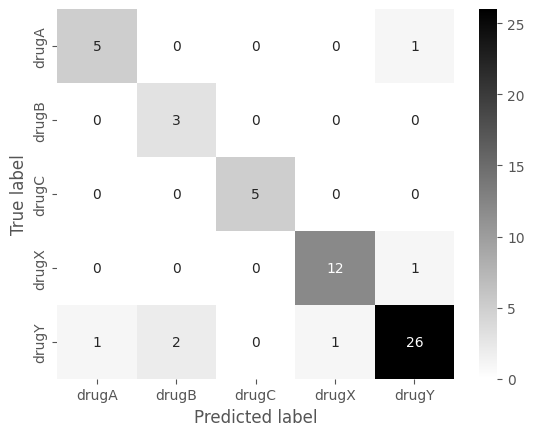

In [ ]:
a = df["Drug"].unique().tolist()
a.sort() 
make_confusion_matrix(confusion_matrix(y_test_bin_ws, predictions), categories= a , cmap='binary')

In [ ]:
print('Classification report')
print(classification_report(y_test_bin_ws, predictions))

Classification report
              precision    recall  f1-score   support

       drugA       0.83      0.83      0.83         6
       drugB       0.60      1.00      0.75         3
       drugC       1.00      1.00      1.00         5
       drugX       0.92      0.92      0.92        13
       drugY       0.93      0.87      0.90        30

    accuracy                           0.89        57
   macro avg       0.86      0.92      0.88        57
weighted avg       0.91      0.89      0.90        57



##### **Compute the Roc Curve for each class**

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
one_hot_encoding = np.array(pd.get_dummies(y_test_bin_ws, columns = ['Drug']))

probs = []
 
for _, model in models_bin_ws:
    model.fit(x_train_bin_ws, y_train_bin_ws)
    proba = model.predict_proba(x_train_bin_ws)
    probs.append(proba)



[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0.

/home/instafiore/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y_train_bin_ws))):
    plt.figure()
    m = 0

    for name, _ in models_bin_ws:
        fpr[i], tpr[i] , _ = roc_curve(one_hot_encoding[:, i], probs[m][:, i])
        
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=5, label=name + f' (area = {roc_auc[i]:.2f})')
        m += 1

    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class = ' + str(np.unique(y_train_bin_ws)[i]))
    plt.legend(loc='lower right')

    plt.show()  

ValueError: Found input variables with inconsistent numbers of samples: [57, 106]

<Figure size 640x480 with 0 Axes>